# w261 Final Project - Air Traffic Departure Delay Prediction

## Spring 2021 Team 4
* **Lina Sheremet**  [lsheremet@berkeley.edu](mailto:lsheremet@berkeley.edu) (EST) / lsheremet (section 1)
* **Julian Tsang**  [juliantsang@berkeley.edu](mailto:juliantsang@berkeley.edu)  (EST) / juliantsang1 (section 1)
* **Stacy Irwin**  [stacy.irwin@berkeley.edu](mailto:stacy.irwin@berkeley.edu)  (PST) / sirwin31 (section 1)
* **Frank Yungfong Tang**  [franktang@berkeley.edu](mailto:franktang@berkeley.edu)  (PST) / FrankYFTang (section 3)

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - EDA & Challenges
* __Section 3__ - Preprocessing / Feature engineering
* __Section 4__ - Algorithm Exploration
* __Section 5__ - Algorithm Implementation
* __Section 6__ - Conclusion
* __Section 7__ - Course Concepts
* __Additional Information__

In [0]:
%sh
git clone https://github.com/sllynn/spark-xgboost.git;
cd spark-xgboost;
pip install -e .;

Cloning into 'spark-xgboost'...
Obtaining file:///databricks/driver/spark-xgboost
Installing collected packages: spark-xgboost
 Running setup.py develop for spark-xgboost
Successfully installed spark-xgboost

In [0]:
# # Restart Python if the installed library raises an ImportError
dbutils.library.restartPython()

In [0]:
import datetime
import json
import math

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType, IntegerType, StructField, StructType, StringType, TimestampType, ShortType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sparkxgb import XGBoostClassifier

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# __Section 1__ - Question Formulation

### Business Case
Commercial flight delays cost the U.S. economy over 30 billion dollars every year. These costs are borne by the airlines, passengers, and the economy as a whole (Ball et al. 2010). Airlines benefit from reducing the number and impact of these delays because fewer delays lead to lower operating costs and greater customer satisfaction.

Airlines engage in many activities that are intended to reduce the cost of flight delays. These activities can be categorized as airline planning activities, which are intended to reduce the likelihood and impact of flight delays, and disruption recovery activities, which attempt to return the transportation network to normal operations quickly and with minimal cost.

Planning activities include (Lee et al., 2020):
* Building buffers into flight schedules to reduce the likelihood that delays will propagate through the system, i.e., that current delays will cause subsequent delays, or that delays at one hub airport will propagate to another hub airport.
* Allocating aircraft to flights and planning cycles for an individual aircraft in a manner that reduces the impact of a single, malfunction aircraft and makes it easier to swap aircraft.

Disruption recovery activities include (Lee et al., 2020):
* Altering flight speed and altitudes to recover time lost to departure delays during the flight.
* Intentionally delaying follow-on flights (departure holds) to enable delayed passengers to make their connections.
* Replacing the aircraft initially assigned to a flight with another aircraft (aircraft swaps). This action could require the airline to fly another aircraft in from a different location without passengers (ferrying).
* Replacing the initially assigned aircrew to prevent exceeding aircrew flight time limitations and ensure minimum pilot rest time requirements are met.
* Reassigning airport gates to avoid conflicts with subsequent, on-time flights.

We have been tasked to predict departure delays of individual flights. These predictions are to be made two hours prior to the flight’s scheduled departure. Because the predictions are to be made in near real-time (two hours before flight departure), the predictions are not useful for an airline’s planning activities. The predictions are useful for disruption recovery activities. Accurately predicting flight delays up to two hours before a flight's departure allows the airline to commence disruption recovery activities earlier. We expect that earlier starts to disruption recovery activities will both increase the range of available recovery activities and reduce their cost.

### Current State of the Art
Several different approaches have been used to addressing flight delays. Operations research techniques, such as queuing theory and stochastic models, have been used by many researchers to model the air transportation network and identify methods to minimize propagation of flight delays and minimize cost (Lee et al., 2020). Other researchers have applied machine learning methods. Yazdi et al. report acheiving up to 96.2% accuracy using a deep learning approach on historical flight data. Aljubairy et al. report acheiving 85.74% accuracy using data derived from the Internet of Things (IoT) and a logistic regression model (Aljubairy et al., 2020).

### Dataset
Our flight delay predictions will be based on historical flight records from the U.S. Bureau of Transportation Statistics and historical weather reports from the U.S. National Oceanic and Atmospheric Administration. The flight dataset includes records for nearly 32 million commercial passenger flights that occurred between 2015 and 2019. Each record includes numerous fields, including origin, destination, scheduled arrival and departure times, actual arrival and departure times, airline, aircraft tail number, delay information, and information on cancellations or diversions. The dataset is imbalanced, with only seventeen percent of flights labeled as being delayed by at least 15 minutes.

The weather dataset includes approximately 20 million weather reports generated by weather stations across the U.S., also from 2015 to 2020. Many of the weather reports address hour by hour weather conditions at commercial airports. The weather reports include information on temperature, cloud cover, visibility, atmospheric pressure, precipitation, and other weather events.

### Classification vs. Regression
Airline flight schedules are designed to tolerate minor delays of a few minutes. Airlines are required to classify a flight as delayed only when it is delayed by fifteen or more minutes. For this initial project, our model will be a binary classification model that predicts whether a flight will be delayed by fifteen or more minutes.

A regression model that predicts the length of a flight delay could be considered for a follow-on project. Such a model  would be useful to airline operations managers. For example, the recovery activities that would be appropriate for a ninety minute flight delay might not be appropriate for a twenty minute flight delay.

### Model Evaluation
A naive model that always predicts that a flight will not be delayed (the majority class) will have approximately 83% accuracy. Such a model would not result in any cost savings to an airline because it would never predict any late flights and enable early recovery actions. For this reason, we will not focus on accuracy when comparing models.

To achieve cost savings, our model must identify a proportion of delayed flights that is sufficient to compensate for the cost of implementing and maintaining the model. The cost savings must also cover the opportunity cost, or the financial benefits that would be realized if the resources needed to implement the model were invested in a different project. To ensure the model provides sufficient cost savings, we will monitor the recall metric, which is the number of correctly identified delayed flights divided by the total number of delayed flights in the dataset.

Recovery actions, such as increasing airspeed to make up time, aircraft of crew swaps, or departure holds all have a cost. If the recovery actions are taken in response to an actual flight delay, the actions will lead to overall cost savings. But if the recovery actions are taken in response to an on-time flight that is erroneously predicted to be delayed (false positive), the actions will increase the cost to the airline and reduce the model's utility. To contain the cost from false positives, we will monitor the precision metric, which is the proportion of flights that are predicted to be delayed that actually are delayed.

The F1 score is the harmonic mean of the recall and precision. We will use the F1 score for delays when comparing models because both adequate recall and adequate precision are required for the model to generate cost savings. Determining the precise values of recall and precision requires that we estimate the following:
* Average cost savings that result from early initiation of recovery actions. This value is equivalent to the cost of a false negative, or a delayed flight that is not identified by the model.
* Average cost of initiating an early recovery action for a flight that is predicted to be delayed by is actually on-time.
Estimation of these costs is beyond the scope of this report.

While our main focus is on the F1-score for delays, we will keep track of other evaluation metrics such as Area under the Curve (AUC) and Area Under Precision Recall Curve (AUPRC). AUC represents how well the model can distinguish between classes. The higher the AUC, the better the model. The baseline AUC is 0.5, where such a model would randomly predict between delay and non-delay.

The AUPRC metric is more relevant in situations where classes are heavily imbalanced, which is the case here since non-delays outnumber delays by approximately a 5:1 ratio. AUPRC takes into account of precision and recall of the positive class for classification problems, where precision is a measure of result relevancy and recall is a measure of how many truly relevant results are returned. Thus, the precision-recall curve shows the tradeoff between precision and recall. A high AUPRC score would reflect a classifier with high recall and high precision, where the classifier would have low false negative rates and low false positive rates, respectively. In other words, the classifier would return accurate results and return a majority of all positive results (correctly identify all delays without marking too many non-delays as delays; able to handle delays correctly).

On the other hand, a classifier with high recall and low precision would return many results, but most of the predicted labels would be incorrect. In addition, when we consider its converse, a classifier with high precision and low recall, it would return few results, but most of the predicted labels would be correct.

The baseline for AUPRC depends on the dataset and is computed by dividing the number of delays over the number of total flights.

### References
1. Ball M, Barnhart C, Dresner M, Hansen M, Neels K, Odoni A, Peterson E, Sherry L, Trani A, Zou B (2010) Total delay impact study, A comprehensive assessment of th ecost and impacts of flight delay in the United States. Technical report, National Center of Excellence for Aviation Operations Research, College Park, MD, https://isr.umd.edu/NEXTOR/pubs/TDI_Report_Final_10_18_10_V3.pdf, (accessed 10 Apr 2021).
2. Lee J, Marla L, Jacquillat A (2020) Dynamic disruption management in airline networks under airport operating uncertainty. *Transportation Science* 54(4):973-997, https://pubsonline.informs.org/doi/10.1287/trsc.2020.0983 (accessed 10 April 2021).
3. Yazdi M, Kamel S, Chabok S, Kheirabadi M (2020) Flight delay prediction based on deep learning and Levenberg-Marquart algorithm. *Big Data* 7:106, https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00380-z (accessed 10 April 2021).
4. Aljubairy A, Zhang W, Shemshadi A, Mahmood A, Sheng Q (2020) A system of predicting flight delays based on IoT data. *Computing* 102:2025-2048, https://www.researchgate.net/publication/339078778_A_system_for_effectively_predicting_flight_delays_based_on_IoT_data (accessed 10 Apr 2021).

# __Section 2__ - EDA & Challenges

#####NOTE: All summaries and conclusions about data in EDA and Feature Engineering are done based on 2015 data ONLY.

The notebook [/Users/stacy.irwin@berkeley.edu/data_pipeline/Get_Joined_Data](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120626689/command/439895120626690) provides a dataframe containing both flight and weather data. The joined data notebook calls two additional notebooks that process the weather and flight data:
* [/Users/stacy.irwin@berkeley.edu/data_pipeline/Get_Weather_Data](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120626286/command/439895120626287)
* [/Users/stacy.irwin@berkeley.edu/data_pipeline/Get_Flight_Data](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120626158/command/439895120626159)

### Flights Data
Detailed description of the flights data could be found in [“Reporting Carrier On-Time Performance (1987-present)”](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).

In [0]:
# Call Get_Joined_Data notebook to get joined airlines-weather data
exit_msg = dbutils.notebook.run(
  r"/Users/stacy.irwin@berkeley.edu/data_pipeline/Get_Joined_Data",
  160, {"data_select": "All-Disk"})
print(exit_msg)
# Get dataframe created by Get_Flight_Data notebook
tbl_name = json.loads(exit_msg)['sql_view']
joined_data_all = spark.sql(f"SELECT * FROM global_temp.{tbl_name};")

joined_data_2015 = (
  joined_data_all
  .where(f.col("YEAR") == "2015")
  .cache()
)
joined_data_2015.createOrReplaceTempView("joined_data")

{"message": "Created a SQL view", "sql_view": "flights_weather", "param": "All-Disk", "timestamp": "2021-04-13 03:40"}

In [0]:
display(joined_data_2015)

join_col,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,FLIGHTS,DISTANCE,DISTANCE_GROUP,week_of_year,FL_WEEK_YEAR,TIMEZONE,CRS_DEP_TIME_UNIX,AVG_ORIGIN_DELAY,AVG_DEST_DELAY,CT_DEL15,DEP_DEL15_NN,ORIGIN_PR,DEST_PR,PRIOR_DEP_TIME,PRIOR_DEL15,PRIOR_DEP_DELAY,REPORT_TYPE,MA1,WND_ANGLE,WND_TYPE,WND_SPEED,WND_ANGLE_CAT,SKY_COND,CAVOC,TMP_CLEAN,VIS_CLEAN,SLP_CLEAN,MA1_CLEAN,PRESSURE,DEW_CLEAN,HUMID_DIFF,HIGH_CHANCE_THUNDER,FOG,SIG_WEATHER,PRECIPITATION,THUNDER_CURRENT,WTR_INTENSITY,WTR_DESC,WTR_PRECIP,WTR_OBSC,WTR_OTR,PRECIP_QUAL,PRECIP_PER,PRECIP_QTY,REPORT_TYPE_arr,MA1_arr,WND_ANGLE_arr,WND_TYPE_arr,WND_SPEED_arr,WND_ANGLE_CAT_arr,SKY_COND_arr,CAVOC_arr,TMP_CLEAN_arr,VIS_CLEAN_arr,SLP_CLEAN_arr,MA1_CLEAN_arr,PRESSURE_arr,DEW_CLEAN_arr,HUMID_DIFF_arr,HIGH_CHANCE_THUNDER_arr,FOG_arr,SIG_WEATHER_arr,PRECIPITATION_arr,THUNDER_CURRENT_arr,WTR_INTENSITY_arr,WTR_DESC_arr,WTR_PRECIP_arr,WTR_OBSC_arr,WTR_OTR_arr,PRECIP_QUAL_arr,PRECIP_PER_arr,PRECIP_QTY_arr,Season
DEN-2015-04-05 19:00:00,2015,2,4,5,7,2015-04-05,WN,19393,WN,N963WN,DEN,"Denver, CO",ABQ,"Albuquerque, NM",1545,1602,17.0,1.0,1500-1559,14.0,1616,1710,4.0,1700,1714,0.0,1.0,349.0,2,14,14-2015,America/Denver,1428270300,1.0,0.6666666666666666,24,1.0,11.119701945681557,0.9523485548730389,1428249900,0,-1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,FM-15,"10142,5,08339,5",240,N,6.7,SouthWest,22000,N,21.1,16093,1007.7,1014.2,1007.7,-7.8,28,0,0,0,None,0,null,null,null,null,null,5,01,0,Spring
PHX-2015-04-05 19:00:00,2015,2,4,5,7,2015-04-05,WN,19393,WN,N935WN,PHX,"Phoenix, AZ",ABQ,"Albuquerque, NM",1400,1420,20.0,1.0,1400-1459,7.0,1427,1612,5.0,1605,1617,0.0,1.0,328.0,2,14,14-2015,America/Phoenix,1428267600,22.105263157894736,3.2,19,1.0,7.206048561882209,0.9523485548730389,1428261000,0,0.0,FM-15,"10095,5,09697,5",190,N,4.6,SouthWest,22000,N,28.9,16093,1007.6,1009.5,1007.6,-4.4,33,0,0,0,None,0,null,null,null,null,null,5,01,0,FM-15,"10142,5,08339,5",240,N,6.7,SouthWest,22000,N,21.1,16093,1007.7,1014.2,1007.7,-7.8,28,0,0,0,None,0,null,null,null,null,null,5,01,0,Spring
SLC-2015-04-05 19:00:00,2015,2,4,5,7,2015-04-05,OO,20304,OO,N805SK,SLC,"Salt Lake City, UT",ABQ,"Albuquerque, NM",1515,1513,-2.0,0.0,1500-1559,19.0,1532,1647,5.0,1653,1652,0.0,1.0,493.0,2,14,14-2015,America/Denver,1428268500,-7.0,6.0,5,0.0,6.566180688515778,0.9523485548730389,1428258600,0,-7.0,FM-16,"10037,5,08593,5",240,N,4.1,SouthWest,22000,N,19.4,16093,null,1003.7,1003.7,-12.8,32,0,0,0,None,0,null,null,null,null,null,null,null,null,FM-15,"10142,5,08339,5",240,N,6.7,SouthWest,22000,N,21.1,16093,1007.7,1014.2,1007.7,-7.8,28,0,0,0,None,0,null,null,null,null,null,5,01,0,Spring
DFW-2015-09-03 12:00:00,2015,3,9,3,4,2015-09-03,AA,19805,AA,N484AA,DFW,"Dallas/Fort Worth, TX",ABQ,"Albuquerque, NM",905,902,-3.0,0.0,0900-0959,35.0,937,959,6.0,959,1005,0.0,1.0,569.0,3,36,36-2015,America/Chicago,1441289100,-3.5161290322580645,null,31,0.0,10.57959805938405,0.9523485548730389,1441281600,0,-10.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,FM-15,"10213,5,08400,5",140,N,2.6,SouthEast,6096,N,18.3,16093,1013.6,1021.3,1013.6,8.9,9,0,0,0,None,0,null,null,null,null,null,5,01,0,Fall
PHX-2015-09-03 12:00:00,2015,3,9,3,4,2015-09-03,WN,19393,WN,N707SA,PHX,"Phoenix, AZ",ABQ,"Albuquerque, NM",745,743,-2.0,0.0,0700-0759,13.0,756,938,4.0,950,942,0.0,1.0,328.0,2,36,36-2015,America/Phoenix,1441291500,-5.428571428571429,-1.5,7,0.0,7.206048561882209,0.9523485548730389,1441283700,0,-5.0,FM-15,"10105,5,09707,5",70,N,2.6,NorthEast,22000,N,28.9,16093,1008.4,1010.5,1008.4,12.8,16,0,0,0,None,0,null,null,null,null,null,5,01,0,FM-15,"10213,5,08400,5"

Taking a look at the flights dataset on its own, we found that all the dates and times are encoded in local time, not UTC. This is something we will have to keep in mind for our join with the weather dataset. The only date information in the data is **FL_DATE** which is the date of the scheduled departure (**CRS_DEP_TIME**). The date, the actual departure time (**DEP_TIME**) , scheduled arrival time (**CRS_ARR_TIME**), and actual arrival time (**ARR_TIME**) could be either on that date, or one day before or after that date- the date of these three other times needs to be carefully calculated from other delay fields. All the local time variables (such as **CRS_DEP_TIME, DEP_TIME, CRS_ARR_TIME, and ARR_TIME**) are encoded in a strange numeral value representation of 100 * hours + minute. In order to use the flight record with other data sets, such as weather data, we need to convert from the local time to UTC but such conversion requires additional information of the time zone of each airport, which is lacking in the data set. Since we are interested in predicting the departure delay, not the arrival delay, and we can only use information two hours prior to the departure time, the UTC time of the scheduled departure time is the key time reference we decided to do our work on.

Relationship of how to link the flights data to the weather data by using the station data set provided by the instructors and additional IATA and ICAO mapping file could be summarized in the following image:
<img width="80%" src ='https://raw.githubusercontent.com/FrankYFTang/images/main/join.png'>


More details can be found in the [Airport Key in the Airline & Weather data
](https://docs.google.com/presentation/d/1ktBcCRf9cQQ0_Vu92MTggNCXbaTqsrx-SXQ-arAC_8c/edit#slide=id.gc3efc35984_0_391) presentation. 


There are 273 different airports in the full dataset, and coded by **ORIGIN** and **DEST**. There are other fields containing similar information that are helpful for displaying / debugging purposes, but are redundant or unnecessary for the purpose of our analysis. The airport is coded by using the **IATA** code. The field **TAIL_NUM** identifies a particular aircraft, and we may use that information to identify the delay status of an aircraft prior to the scheduled flight. The field **OP_CARRIER** identifies the airline company- there are other fields associated with that, but these are again either redundant or unnecessary for the purpose of our analysis. **MONTH**, **QUARTER**, **DAY_OF_WEEK** are variables with numerical value, but they encode a cycle of time, and therefore should be treated as categorical variables. A week day of 7 is not greater than or less than a week day of 6. Rather, the two represent different categories. They are useful categorical variables to capture the relationship between delay on different cycles of time periods. We also later calculate a **week_of_year** as a time cycle between **MONTH** and **DAY_OF_WEEK**.

**DEP_TIME_BLK** and **ARR_TIME_BLK** are string variables which represent the bucket of departure and arrival time in the airport of each day. They are useful categorical variables to capture the relationship between delay and local time of each day. **DISTANCE** is a numerical variable that we could use to approximate the length of each flight. Since time is progressing and we will never experience the day time as before, we believe we cannot use **YEAR** nor **FL_DATE** directly as a feature, but can only use them to assist to convert other fields for the purpose of joining. While we believe **ORIGIN**, **DEST**, **TAIL_NUM**, and **OP_CARRIER** may provide us some useful information, we believe it is not appropriate to directly use them as a feature for our classification for the risk of overfitting. We later run a page rank algorithm on **ORIGIN** and **DEST** (described in feature engineering) to find out the importance of each airport in the air traffic network and use that ranking value as a feature (**ORIGIN_PR** and **DEST_PR**). We also use **TAIL_NUM** to deduct the flight delay information of the same aircraft several hours before the scheduled flight of our interest as a feature (**PRIOR_DEL15**, **PRIOR_DEP_DELAY**, **PRIOR_DEP_TIME**) , and use Weight of Evidence encoding on **OP_CARRIER** to represent the tracking record of an airline company. We also believe the delay information several hours prior to the scheduled flight of our interest in the same airport may help us to detect possible delay, we calculate the overall flight delay of each airport, 2 to 3 hours before the scheduled flight in **AVG_ORIGIN_DELAY**, **AVG_DEST_DELAY**, **CT_DEL15** as feature.

### Time and Duration Information
We found some interesting issues related to time and duration in the flights data:
* The only information of date in the flight data is **FL_DATE** which is associated with **CRS_DEP_TIME**.
* **FL_DATE** is not necessary the day for the **DEP_TIME** since it is possible that a flight is scheduled to fly on 23:59 of **FL_DATE** but actually take off 00:05 the next day of **FL_DATE** if there is a 6 minutes delay and in that case the date of the **DEP_TIME** is actually the day after the **FL_DATE**. The date of the **DEP_TIME** could also be one day earlier than **FL_DATE** if a flight is scheduled in **CRS_DEP_TIME** as 00:05 of **FL_DATE** but actually close the gate 7 minutes earlier at 23:58 the day before. 
* **FL_DATE** is also not necessary the day for the **CRS_ARR_TIME**. The obvious reason is is the flight may take off close to midnight and landed in the **DEST** airport the next day. However, it is also possible that the date of the **CRS_ARR_TIME** is one day earlier of the **FL_DATE** when the duration of a flight is less than 60 minutes between two airports of different time zones- for example a flight scheduled to take off on 00:05 of **FL_DATE** in an airport located in Eastern Timezone which take 50 minutes to travel time could be scheduled to arrive on 23:55 of the day before **FL_DATE** in the arriving airport which is in the Central Time time zone.
* Therefore we found the best way to transform the UTC for all necessary fields, is to use **FL_DATE** and **CRS_DEP_TIME** to convert it to UTC first, and use all other "duration" information (see below) to calculate the UTC of other fields from that UTC.

The following "duration" information is encoded in the unit of minutes in the flights data set:
* **DEP_DELAY**: The time difference, in the unit of minutes, between **DEP_TIME** and **CRS_DEP_TIME**.
* **TAXI_OUT**: The time difference, in the unit of minutes, between **WHEEL_OFF** and **DEP_TIME**.
* **AIR_TIME**: The time difference, in the unit of minutes, between **WHEEL_ON** and **WHEEL_OFF**.
* **TAXI_IN**: The time difference, in the unit of minutes, between **ARR_TIME** and **WHEEL_ON**.
* **ARR_DELAY**: The time difference, in the unit of minutes, between **ARR_TIME** and **CRS_ARR_TIME**.
* **CRS_ELAPSED_TIME**: The time difference, in the unit of minutes, between **CRS_ARR_TIME** and **CRS_DEPT_TIME**.
* **ACTUAL_ELAPSED_TIME**: The time difference, in the unit of minutes, between **ARR_TIME** and **DEPT_TIME**.

The following image summarizes the relationships between different time and duration fields in the flights data:
<img width="80%" src='https://raw.githubusercontent.com/FrankYFTang/images/main/flights_time.png'>

Below, we examine the ratio of flight delay based on the category of different time cycles. We notice the ratio of delay flights has higher variance when grouping by **DEP_TIME_BLK** and **week_of_year**. The average delay ratio grouped by **DEP_TIME_BLK** shows us that the departure delay ratio within a day is lowest at 8% between 6:00-6:59 and highest at 29% between 20:00-20:59.The average delay ratio grouped by **MONTH** shows us that the departure delay ratio within a year, if we divided by month,  is lowest at 12%  during August and September and highest at 26% in February.The average delay ratio grouped by **DAY_OF_WEEK** shows us that the departure delay ratio within a week  is lowest at 18%  on Saturday  and highest at 22% on Monday.The average delay ratio grouped by **Season** shows us that the departure delay ratio within a week  is lowest at 14%  during Fall  and highest at 23% during Winter.The average delay ratio grouped by **week_of_year** shows us that the departure delay ratio within a year, if we divided by week,  is lowest at 11% during a week in September and highest at 40% in the last week of the year.

In [0]:
def plotBar(df, col, ax):
  # Plot bar plot of ratio of col in df, the ratio is stored in 'DELAY_PERCENT'
  bar = ax.bar(list(range(len(df[col]))), df['DELAY_PERCENT'], align='center')
  ax.set_xticks(np.arange(len(df[col])))
  ax.set_xticklabels(df[col], rotation = 90)
  ax.set_ylabel('Delay Ratio')
  ax.set_xlabel(col)
  ax.set_title(col)
  
def plotRatioBar(cols):
  plt.figure(figsize=(5*len(cols), 5))
  # Iterate over cols in joined_data, each col in cols is a categorical variable
  # Use SQL to create the ratio of DEP_DEL15_NN into DELAY_PERCENT as a pandas dataframe.
  # Then call plotBar to plot
  for i in range(len(cols)):
    col = cols[i]
    q = f"""
    SELECT {col}, sum(DEP_DEL15_NN) / count(*) AS DELAY_PERCENT
    FROM joined_data
    GROUP BY {col}
    ORDER BY {col}
    """
    # Create the Pandas dataframe by using SQL
    df = spark.sql(q).toPandas()
    ax = plt.subplot(1, len(cols), i+1)
    # Plot the ratio bar into the subplot
    plotBar(df, col, ax)
  plt.show()

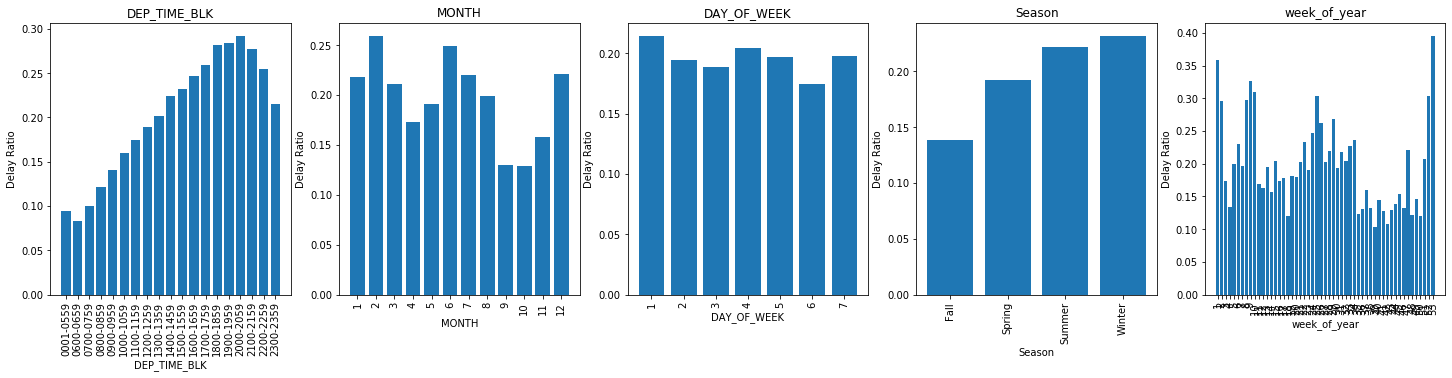

In [0]:
plotRatioBar(['DEP_TIME_BLK','MONTH', 'DAY_OF_WEEK', 'Season', "week_of_year"])

We also found the ratio of delayed flights group by **TAIL_NUM** and **OP_CARRIER** are very different between each group. **NK (SPIRIT WINGS)** has the highest ratio of delay (28.6%) and **HA (HAWAIIAN)** has lowest ratio of delay (7.5%). For the **TAIL_NUM**, we found the value of null is all delayed. This is because if a flight is cancelled it won’t have a **TAIL_NUM** in the record and therefore all the null **TAIL_NUM** is delayed. Beside that there are several aircrafts that only fly a handful of times and all with delayed statuses. We also notice that for aircrafts which have delay status 2 to 8 hours prior to the scheduled departure, the ratio of delay is as high as 63% while those without prior delay status have only a 15% of chance of delay.

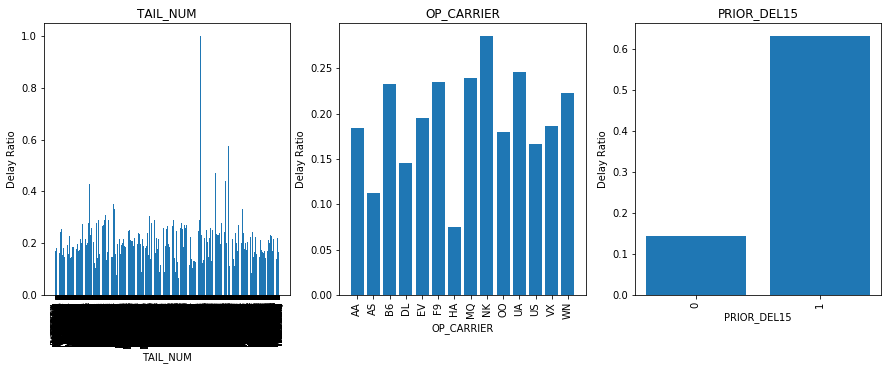

In [0]:
plotRatioBar(['TAIL_NUM', 'OP_CARRIER', 'PRIOR_DEL15'])

In [0]:
def plotBoxPlots(df, cols):
  # Iterate through cols in df, which each is a continous variable
  # and then plot box plot based on the 'DEP_DEL15_NN'
  plt.figure(figsize=(5*len(cols), 5))
  # Since the data set is huge we only sample 1% of the data for boxplot
  sdf = df.sample(0.01).select(['DEP_DEL15_NN'] + cols).toPandas()
  # Iterate through each col in cols
  for i in range(len(cols)):
    col = cols[i]  
    ax = plt.subplot(1, len(cols), i+1)
    sns.boxplot(x="DEP_DEL15_NN", y=col, data=sdf, ax=ax)
    ax.set_title(col)
  plt.show()
  
# Plot the scatter plot of x vs y, which are both continous variables and use
# the value 'DEP_DEL15_NN' for the color. Since the data set is big, we only
# randomly sample 0.05% of the data for the plot.
def plotScatterPlots(df, x, y):
  sns.scatterplot(x=x, y=y, hue="DEP_DEL15_NN", data=df.sample(0.0005).select(['DEP_DEL15_NN', x, y]).toPandas())

Below, we can see box plots of flight variables split by whether the flight was delayed or not. **DEP_DEL_15_NN** in the boxplots below is a representation of our dependent variable with null values replaced with 1s (cancelled/diverted will count as delayed). These variables are described in further detail in the feature engineering section. We can see that departure delay for previous flights in the day at that airport seems to be higher for a delayed flight. The same can be seen with the number of flights delayed greater than 15 minutes earlier in the day. Average origin/ departure delay do not clearly seem to vary much between delayed/on-time flights.

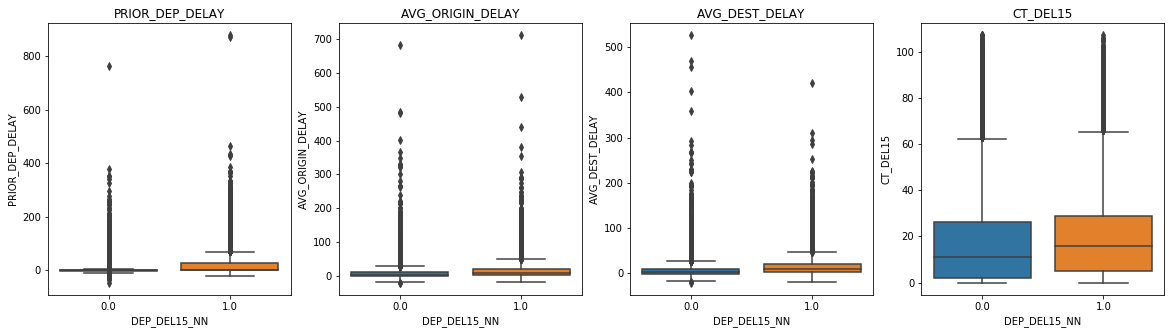

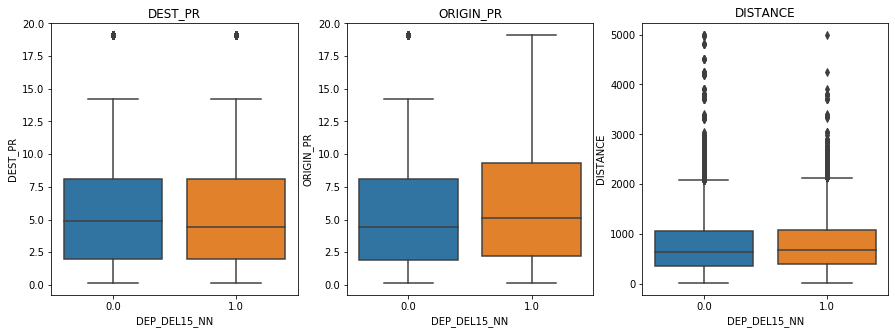

In [0]:
plotBoxPlots(joined_data_2015, ['PRIOR_DEP_DELAY', 'AVG_ORIGIN_DELAY', 'AVG_DEST_DELAY', 'CT_DEL15'])
plotBoxPlots(joined_data_2015, [ 'DEST_PR', 'ORIGIN_PR', 'DISTANCE'])

Below is a scatterplot of the prior departure delay for that tail number VS the average origin delay for the airport, colored by whether the flight was delayed or not. We can see that the extreme values of average origin delay and prior departure delay usually end up being being delays, which may indicate that these variables may be predictive in our model. Low values for each (the points close to the origin) are almost all blue (on-time flights).

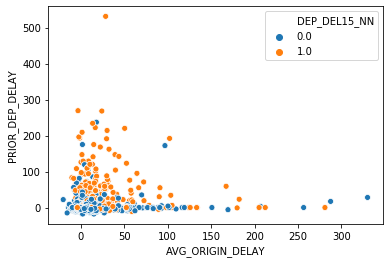

In [0]:
plotScatterPlots(joined_data_2015, 'AVG_ORIGIN_DELAY', 'PRIOR_DEP_DELAY')

### Weather Data
Detailed description of the flights data could be found in 
[“ Integrated Surface Database (ISD) Formar Docuemnt”](https://www1.ncdc.noaa.gov/pub/data/ish/ish-format-document.pdf) and 
[“How We Process the NOAA Integrated Surface Database Historical Weather Data”]()

Our weather dataset, obtained from the National Oceanic and Atmospheric Administration repository, contains 630,904,436 rows and 177 columns about the weather conditions of specific airports at a specific date and time. As previously mentioned, we are choosing to focus only 2015. Our filtered dataset contains 5,023,152 rows. The dataset is made up of 3 parts: the control data section, the mandatory data section, and the additional data section. The control data section provides descriptive information about the report including date, time, and station location information. The mandatory data section contains meteorological information on basic elements such as winds, visibility, and temperature. The data in this section is comprehensive. Lastly, the additional data section contains data that is not necessarily collected at the same degree of frequency. It is much more sparse.

##### Control data section:

The control data section contains the station number, the date and time of the weather information, the source, which describes the origin of the weather information, the latitude & longitude of the location, the elevation relative to the mean sea level, the name of the airport, the report type, denoting the type of geophysical surface observation, the call sign, and the quality control process applied to the weather observation. Most of these control variables, except station and latitude/longitude, will not prove important for our purposes.

##### Mandatory data section:

The mandatory data section contains 6 variables that are mostly complete. One common factor in each of these variables is the fact that there is often a "quality" code attached to almost every observation. This code is a value 0-9, which each number being assigned to a quality status. Some statuses signify data that passed quality control checks, while others signify that the data point may be erroneous or suspect.

After exploring the weather data, we notice that the date/time information is stored in UTC and the location of the station which measures this information is encoded in the **STATION** field, which is a string connotation of the USAF and the WBAN identifier. 

For numerical variables, we use boxplots to exam the distribution of these variable of both the delayed and on-time flights. The variables below are described in more detail in the feature engineering section. 

We can see that wind speed is generall higher for delayed flights. In addition, sky condition, which represents how far of a distance one can see in the sky, is lower for delayed flights. Temperature does not vary much with delayed VS non-time flights, though surprisingly the lower temepratures are seen in flights that are on-time. Air pressure, and does not vary much between delayed and non-delayed flights. These patterns remain consistent for arrival weather as well, except for arrival sky condition, which does not seem to vary between delayed/on-time flights.

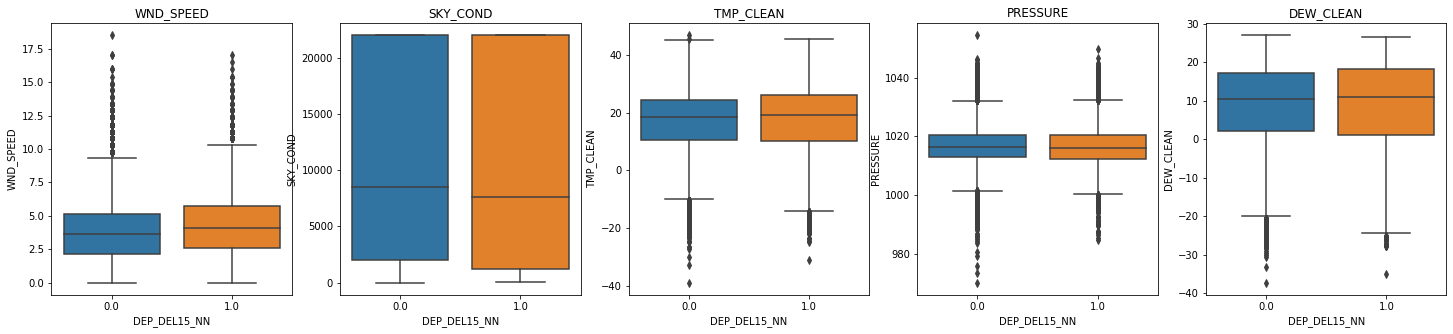

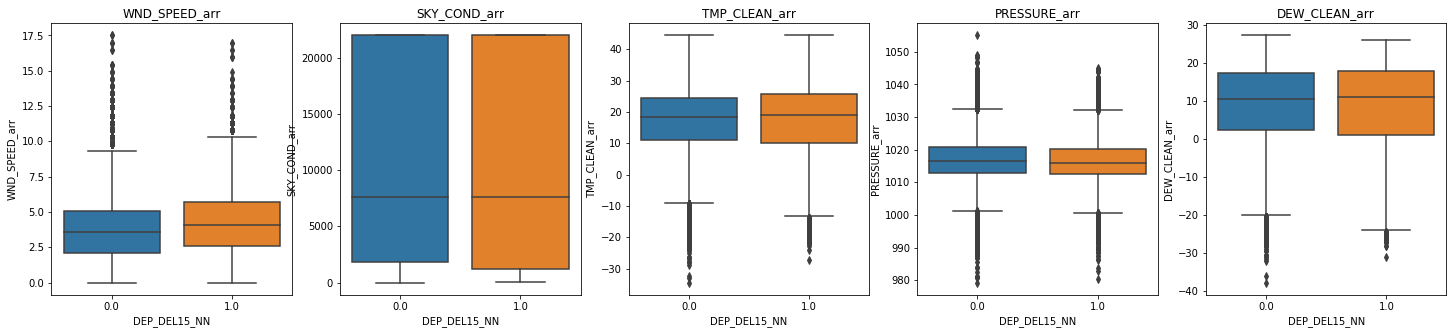

In [0]:
plotBoxPlots(joined_data_2015, ['WND_SPEED', 'SKY_COND', 'TMP_CLEAN', 'PRESSURE', 'DEW_CLEAN'])
plotBoxPlots(joined_data_2015, ['WND_SPEED_arr', 'SKY_COND_arr', 'TMP_CLEAN_arr',  'PRESSURE_arr', 'DEW_CLEAN_arr'])

Below is a scatterplot of dew point and temperature (both in Celcius) colored by whether the flight was delayed or not. There is a clear linear relationship between dew point and temperature. However, they dont seem to be very related to the flight being delayed. We also see a scatterplot of

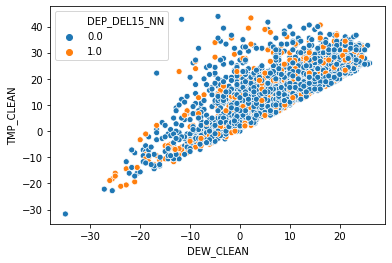

In [0]:
plotScatterPlots(joined_data_2015, 'DEW_CLEAN', 'TMP_CLEAN')

### Flights and Weather

We also found that in order to join the flights data and weather data together, we need a way to link these two data sets together. The location of flights data is keyed by **IATA** code and the location of the weather data is keyed in the **STATION** code.

* The **IATA** airport code is a three-letter geocode designating many airports and metropolitan areas around the world, defined by the [International Air Transport Association (IATA)](https://en.wikipedia.org/wiki/IATA_airport_code)
* The **ICAO** airport code is a four-letter code designating aerodromes around the world, as defined by the [International Civil Aviation Organization and published in ICAO Document 7910: Location Indicators](https://en.wikipedia.org/wiki/ICAO_airport_code), are used by air traffic control and airline operations such as flight planning. 
* **USAF** is A character string identifying the fixed weather station from the [USAF Master Station Catalog](https://rich-iannone.github.io/stationaRy/reference/get_station_metadata.html). USAF is an acronym for United States Air Force. 
* **WBAN** is A character string for the fixed weather station NCDC [WBAN identifier](https://rich-iannone.github.io/stationaRy/reference/get_station_metadata.html). NCDC is an acronym for National Climatic Data Center. WBAN is an acronym for Weather Bureau, Air Force and Navy. 
* The **STATION** code in the weather data set is just a concatenation of the **USAF** and **WBAN** code.

Comparing some of our features to one another, we can see that the largest correlation is between temperature and dew. This makes sense, as a combination of the two signifies humidity, and the two are often similar. Another strong correlation is between **DEP_DEL15** (whether the flight was delayed by at least 15 mins or not) and **PRIOR_DEL15** (a binary variable for a flight with the same tail number that was delayed by at least 15 minutes in a prior period). This makes sense, as previous delays will often indicate future delays. Temperature and significant weather are slightly negatively correlated, which makes sense as it is less likely that there will be a significant snow/rain storm when the temperature is higher. The average origin and destination delays are positively correlated, as one could often impact the other. However, the only strong correlation (absolute value > 0.5) was between temperature and dew point.

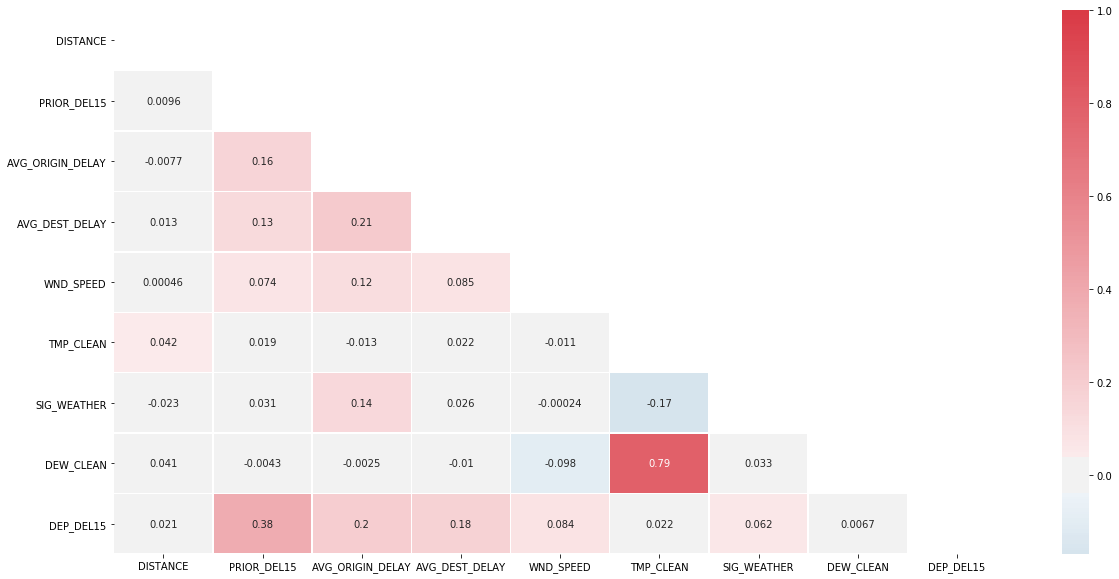

In [0]:
## corelation matrix
target_features = [
  "DISTANCE",
  "PRIOR_DEL15",
  "AVG_ORIGIN_DELAY",
  "AVG_DEST_DELAY",
  "WND_SPEED",
  "TMP_CLEAN",
  "SIG_WEATHER",
  "DEW_CLEAN",
  "DEP_DEL15"
]
def plotCorr(df, target_features):
  corr = df.select(target_features).toPandas().corr()
  # Plotting the correlation matrix
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  cmap = sns.diverging_palette(240, 10, as_cmap=True)
  fig, ax = plt.subplots(figsize=(20,10))
  sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, annot=True)
  
plotCorr(joined_data_2015, target_features)

# __Section 3__ - Feature Engineering

### Feature Engineering in Flights Data
Notebook providing flight data: [/Users/stacy.irwin@berkeley.edu/data_pipeline/Get_Flight_Data](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120626158/command/439895120626159)

In [0]:
# Call Get_Flight_Data notebook to get airline data
exit_msg_flt = dbutils.notebook.run(
  r"/Users/stacy.irwin@berkeley.edu/data_pipeline/Get_Flight_Data",
  60, {"flight_data_select": "All-Disk"})
print(exit_msg_flt)

# Get dataframe created by Get_Flight_Data notebook
tbl_name = json.loads(exit_msg_flt)['sql_view']
airlines_all = spark.sql(f"SELECT * FROM global_temp.{tbl_name};")

airlines_2015 = airlines_all.filter(f.col("YEAR") == "2015")

{"message": "Created a SQL view", "sql_view": "Flights", "param": "All-Disk", "timestamp": "2021-04-13 03:07"}

#### Airport Code Mapping
Once we got to the join portion of our feature engineering, we determined we needed to find a way to join station codes and  IATA + ICAO in order to eventually join the weather and flight data. Thus, to make this possible, one of the first feature engineering steps we took on our flight data was adding in the columns we would later need for our join using a separate dataset we imported for the project, as well as station data we were given (Section 2-5 of Get_Flight_Data). To do this, we first created a list of distinct airports in the flight dataset, and joined those with the IATA datasets we had, to create a sort of dimension table for each airport (Section 3 of Get_Flight_Data). We noticed there was some missing data for airports SWO, OGD, USA, XWA, and YAK, so we manually filled this in (Section 4 of Get_Flight_Data). Lastly, we created our final dataset using a broadcast join. We joined our original flight data on this lookup table to obtain the columns we would need for our weather-flight join later on.

#### Mapping Time from Local Time to UTC
Something else we would need for the join later on is to have all the flight times in UTC instead of local time, as the weather data only contained UTC and working with local time would be messy. We created UTC versions of both **CRS_DEP_TIME** and **CRS_ARR_TIME**, in both string and timestamp types. These new columns were called **CRS_DEP_TIME_UTC_TS**, **CRS_DEP_TIME_UTC**, **CRS_ARR_TIME_UTC_TS**, and **CRS_ARR_TIME_UTC** (Section 5 of Get_Flight_Data).

We use the local airport code **ORIGIN**  to find out the timezone of the departure airport, then we use it with the **FL_DATE** and **CRS_DEP_TIME** to calculate the value in UTC and encoded in **CRS_DEP_TIME_UTC_TS**, **CRS_DEP_TIME_UTC** . We then use **CRS_DEP_TIME_UTC_TS** and **CRS_ELAPSED_TIME** to calculate **CRS_ARR_TIME_UTC_TS**, and **CRS_ARR_TIME_UTC**.

#### Response Variable

Our response variable had quite a few nulls. We noticed that these nulls often signified cancellations or diverted flights. Because we had no way of knowing for sure whether this would signify a departure delay of 15 minutes or more, and we determined that these instances would probably cause a delay, we converted the null rows to 1 (Section 7 of Get_Flight_Data) and encoded it as **DEP_DEL15_NN**.

Originally, we had some discussions on what features to use in our models from the flights dataset. We wanted to use airport or tail number, but we knew this would be overfitting if we got data with new airports or a new airport opened up at a certain point later in time. We also wanted a day to describe the general "delay" state of an airport, without overfitting. Thus, we decided that we would want to encode some of these features, described below.

#### Average Prior Delays
We hypothesized that a flight is more likely to be delayed if many other flights at the same airport are delayed. This theory is supported by Lee et al. (detailed reference in secction 1), who report that a single flight is just one element of a larger interconnected network, and that delays will tend to propagate to future flights, both at the original airport and connected airports. To estimate the delay state of an airport at a given time, we used a SQL window query to identify the delays at the origin and destination airports that occurred between three and two hours prior to a flight's scheduled departure time. We created features for the average delay in minutes (**AVG_ORIGIN_DELAY**, **AVG_DEST_DELAY**), and the number of flights delayed by greater than 15 minutes (**CT_DEL15**). 

Although our final code for calculating the delay state of an airport used pySpark functions, the logic is equivalent to the following SQL window query.
* **CRS_DEP_TIME_UNIX** is a Unix timestamp version of the **CRS_DEP_TIME** column. It represents departure time as the number of seconds that have elapsed since 1 January 1970. Using Unix timestamps to calculate prior time windows avoids errors that can be caused by time periods that span day or month boundaries.
* For every flight, the window query retrieves all flights occuring at the origin or destination airport that departed within three and two hours (10,800 and 7,200 seconds) prior to the current flight. The query then calculates average departure delays for earlier flights at both the origin and destination, and counts the number of flights that were delayed by more than 15 minutes at the origin.

```sql
SELECT *,
  AVG(DEP_DELAY) OVER origin_window AS AVG_ORIGIN_DELAY,
  AVG(DEP_DELAY) OVER dest_window AS AVG_DEST_DELAY,
  COUNT(DEP_DEL15) OVER origin_window AS CT_DEL15
FROM flights
                      
WINDOW origin_window AS (PARTITION BY ORIGIN ORDER BY CRS_DEP_TIME_UNIX
                         RANGE BETWEEN 10800 PRECEEDING AND 7200 PRECEEDING)
WINDOW dest_window AS   (PARTITION BY DEST ORDER BY CRS_DEP_TIME_UNIX
                         RANGE BETWEEN 10800 PRECEEDING AND 7200 PRECEEDING);
```

The average of **AVG_ORIGIN_DELAY** and **AVG_DEST_DELAY** were both around 8 mins. The average of **CT_DEL15** was 18, which was surprisingly large, and the distribution was right skewed.

summary,AVG_ORIGIN_DELAY
count,4898869
mean,8.780620572650639
stddev,20.402667843502226
min,-55.0
max,1544.0


/databricks/python/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
 keep = (tmp_a >= first_edge)
/databricks/python/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
 keep &= (tmp_a <= last_edge)

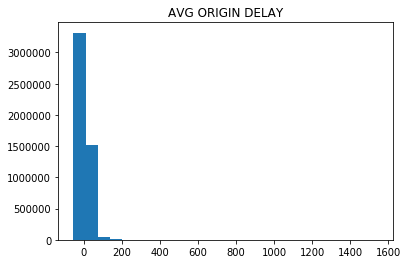

summary,AVG_DEST_DELAY
count,5104811
mean,8.518245738301095
stddev,18.525525780664154
min,-68.0
max,1136.0


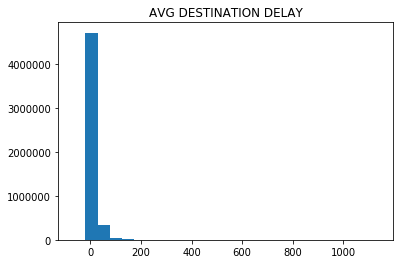

summary,CT_DEL15
count,5850543
mean,18.140522854032522
stddev,19.678005826638742
min,0
max,110


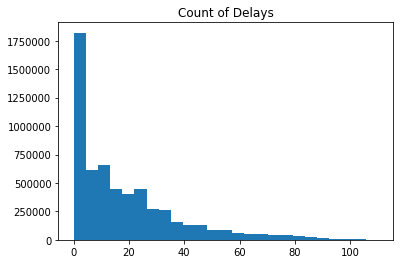

In [0]:
# avg origin delay summary
display(airlines_2015.select('AVG_ORIGIN_DELAY').describe())

# avg origin delay histogram
airlines_origin_delay = list(airlines_2015.select('AVG_ORIGIN_DELAY').toPandas()['AVG_ORIGIN_DELAY'])
plt.hist(airlines_origin_delay, bins = 25)
plt.title("AVG ORIGIN DELAY")
display(plt.show())

#avg destination delay summary
display(airlines_2015.select('AVG_DEST_DELAY').describe())

#avg destination delay hist
airlines_dest_delay = list(airlines_2015.select('AVG_DEST_DELAY').toPandas()['AVG_DEST_DELAY'])
plt.hist(airlines_dest_delay, bins = 25)
plt.title("AVG DESTINATION DELAY")
display(plt.show())

# count of delays summary
display(airlines_2015.select('CT_DEL15').describe())

# count of delays hist
airlines_ct_delay = list(airlines_2015.select('CT_DEL15').toPandas()['CT_DEL15'])
plt.hist(airlines_ct_delay, bins = 25)
plt.title("Count of Delays")
display(plt.show())

#### Capturing Airport Characteristics
Out dataset includes both the origin and destination airports. We hypothesized that different airports would have different susceptibility to delays depending on their volume of flights, hub status, and how they connect to other airports. We were concerned that retaining the airport identifier as a feature would make our models more susceptible to overfitting, so we calculated a PageRank metric for each airport. We ran the GraphFrames PageRank algorithm on a graph where each node is an airport, and each edge is a flight between two airports. We used all flights that occurred in 2017 to create the graph, since 2017 falls in the middle of the dataset and does not appear in our test dataset. Instead of a random web surfer, our PageRank uses a random air traveler, who randomly picks a flight to go to the next airport. There is a probability of 0.15 that the random traveler will magically teleport to another airport instead of taking a flight. To keep things simple, we allowed our random traveler to time travel by taking any flight departing from an airport, even if it had departed before their incoming flight arrived. The resulting PageRank list appears to capture the airport flight volume and centrality. The top two airports are Atlanta and Chicago, and the bottom two airports are in Tokeen, AK and Stillwater, OK. [The PageRank code is available in this notebook.](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/528073926734956/command/528073926734957).

In [0]:
# Display top 5 and bottom 10 airports by PageRank
airports_pr = (spark
               .read
               .option("header", "true")
               .parquet("dbfs:/user/stacy.irwin@berkeley.edu/PJ/airport_pagerank_2017/")
              )

print("Top five airports by PageRank")
display(airports_pr
        .orderBy(f.col("pagerank").desc())
        .take(5))

print("Bottom five airports by PageRank")
display(airports_pr
        .orderBy(f.col("pagerank"))
        .take(5))

Top five airports by PageRank

id,city,pagerank
ATL,"Atlanta, GA",19.079782319030798
ORD,"Chicago, IL",14.212973830180855
DEN,"Denver, CO",11.119701945681557
DFW,"Dallas/Fort Worth, TX",10.57959805938405
LAX,"Los Angeles, CA",9.347744434516466


Bottom five airports by PageRank

id,city,pagerank
TKI,"Tokeen, AK",0.1782834405577306
SWO,"Stillwater, OK",0.17832051665097032
FNL,"Fort Collins/Loveland, CO",0.17832783562631677
BPT,"Beaumont/Port Arthur, TX",0.17863051704844166
GGG,"Longview, TX",0.17868009940425755


In [0]:
# origin page rank summary
display(airlines_2015.select('ORIGIN_PR').describe())

# origin page rank hist
airlines_o_pr = list(airlines_2015.select('ORIGIN_PR').toPandas()['ORIGIN_PR'])
plt.hist(airlines_o_pr, bins = 25)
plt.title("Page Rank Origin Airports")
display(plt.show())

# destination page rank summary
display(airlines_2015.select('DEST_PR').describe())

#destination page rank hist
airlines_d_pr = list(airlines_2015.select('DEST_PR').toPandas()['DEST_PR'])
plt.hist(airlines_d_pr, bins = 25)
plt.title("Page Rank Destination Airports")
display(plt.show())

#### Prior Delays for Specific Aircraft

Often times, flights are delayed because the aircraft that was scheduled for the flight had a previous delay on another flight. Because of this, we created **PRIOR_DEL15**, a binary variable that indicated if there was a prior delay of at least 15 minutes during a time window starting eight hours before scheduled departure time and ending two hours before scheduled departure time. We concluded that eight hours is sufficient time to account for most domestic flights. Departures for longer international flights, like New York to Dubai or Seattle to Taipai would not appear in this window, but we expect that aircraft on these routes would have longer turn-around times and would be better able to withstand a departure delay.

We also created **PRIOR_DEP_DELAY**, which is the same as **PRIOR_DEL15**, except that it contains the delay in minutes for the prior flight with the same tail number, regardless of whether the delay was 15 minutes or longer. Lastly, we created **PRIOR_DEP_TIME**, which is the time of the prior delay for the same tail number. This feature would include null records for the first record in the dataset for any given tail number and it ignores the 8-hour prior time window.

We used a nested SQL query (see below) to determine if the aircraft assigned to a flight had already been delayed earlier in the day.
* The first phase of the SQL query identifies the prior departure time for the aircraft assigned to each flight. In addition the query identifies whether the flight was delayd by at least 15 minutes and the length of the delay in minutes.
* The second phase checks whether the prior departure occurred between eight and two hours prior to the current depature. The query creates **PRIOR_DEP_DELAY** and **PRIOR_DEL15** columns that contains the departure delay in minutes for the prior flight and a binary value indicating if the flight was delayed by at least 15 minutes, *if* the prior departure occurred within the eight to two hour time window. Otherwise, the column is set to 0.

```sql
WITH flights_tail AS (
  SELECT *,
  LAG(CRS_DEP_TIME_UNIX, 1) OVER tail_window AS PRIOR_DEP_TIME,
  LAG(DEP_DEL15_NN, 1) OVER tail_window AS PRIOR_DEL15_raw,
  LAG(DEP_DELAY, 1) OVER tail_window AS PRIOR_DEP_DELAY_raw
  from flights
  WINDOW tail_window AS (PARTITION BY TAIL_NUM ORDER BY CRS_DEP_TIME_UNIX)
)
SELECT *,
  CASE WHEN CRS_DEP_TIME_UNIX - PRIOR_DEP_TIME >= 7,200 AND
            CRS_DEP_TIME_UNIX - PRIOR_DEP_TIME <= 28,800 AND
            PRIOR_DEL15_raw = 1 THEN 1
       ELSE 0
  END AS PRIOR_DEL15,
  CASE WHEN CRS_DEP_TIME_UNIX - PRIOR_DEP_TIME >= 7,200 AND
            CRS_DEP_TIME_UNIX - PRIOR_DEP_TIME <= 28,800 AND
            PRIOR_DEP_DELAY_raw IS NOT NULL THEN PRIOR_DEP_DELAY_raw
       ELSE 0
  END AS PRIOR_DEP_DELAY
FROM flights_tail;
```

We can see that most prior flights were not delayed, which is consistent with what we found in the EDA section. The average prior delay for the same tail number is 4 minutes, with a maximum of 1429 minutes.

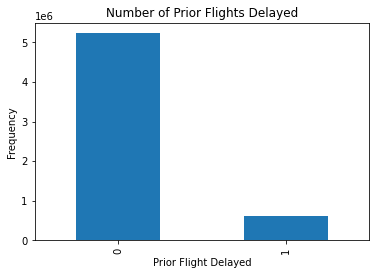

summary,PRIOR_DEP_DELAY
count,5850543
mean,4.4394916847889165
stddev,24.084419559538144
min,-82.0
max,1429.0


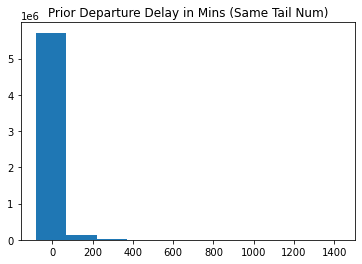

In [0]:
# bae chart of prior flights delayed count
ax = airlines_2015.select('PRIOR_DEL15').toPandas()['PRIOR_DEL15'].value_counts().plot(kind='bar',
                                    title="Number of Prior Flights Delayed")
ax.set_xlabel("Prior Flight Delayed")
ax.set_ylabel("Frequency")
plt.show()

# summary of prior delay
display(airlines_2015.select('PRIOR_DEP_DELAY').describe())

# hist of prior delays
airlines_o_pr = list(airlines_2015.select('PRIOR_DEP_DELAY').toPandas()['PRIOR_DEP_DELAY'])
plt.hist(airlines_o_pr)
plt.title("Prior Departure Delay in Mins (Same Tail Num)")
display(plt.show())

### Feature Engineering in Weather Data
Notebook providing weather data: [/Users/stacy.irwin@berkeley.edu/data_pipeline/Get_Weather_Data](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120626286/command/439895120626287)

In [0]:
exit_msg_wtr = dbutils.notebook.run(
  r"/Users/stacy.irwin@berkeley.edu/data_pipeline/Get_Weather_Data",
  180, {"weather_data_select": "All-Disk",
       "format_select": "filtered_processed"})
print(exit_msg_wtr)
# Get dataframe created by Get_Flight_Data notebook
tbl_name = json.loads(exit_msg_wtr)['sql_view']
weather_all = spark.sql(f"SELECT * FROM global_temp.{tbl_name};").cache()

weather_2015 = weather_all.filter(f.year("DATE") == 2015)

{"message": "Created a SQL view", "sql_view": "weather", "param": "All-Disk", "timestamp": "2021-04-12 02:48"}

Because the weather data we were working with was so large and it was difficult to perform any task, our first priority was filtering it down as much as we could. Thus, we started by performing our first join, taking an inner join of weather data to a previous dataframe we had created with only the stations that existed in the airport data. We noticed that repartitioning our data improved performance, so we repartitioned our filtered down weather data using station (Section 3 of Get_Weather_Data). 

Prior to performing any feature engineering, we trimmed white spaces in our columns and replaced any blanks with nulls, as Spark handles nulls more efficiently (Section 4 of Get_Weather_Data). Yet another form of cutting down data we performed is filtering out any weather reports whose report type was not FM-15 or FM-16. Report types such as SOM, SOD, and FM-12 were indicative of a weather report summary, instead of a point-in-time metric. We were only interested in determining current weather conditions (Section 5 of Get_Weather_Data). This filtered down the data by 10%, to 4,084,956 rows.

Again, the weather dataframe is very large and has many fields that are very sparse and not useful. Thus, we filtered down the whole dataset on only the following variables: **DATE**, **ORIGIN**, **REPORT_TYPE**, **WND**, **CIG**, **VIS**, **TMP**, **DEW**, **SLP**, **AU1**, **AA1**, **AW1**, **AW2**, **AW3**, **AW4**, **AW5**, **MA1**. The first 3 are part of the control section, and will help characterize the weather report. The next 6 are part of the mandatory weather report, where all data is complete. The last 8 are from the additional columns list. We found these to be potentially useful in building a model despite their sparse nature (Section 7 of Get_Weather_Data). 

As we mentioned in the EDA section, each weather column is comma separated and may contain multiple fields, each with a quality code associated with it. The fields are described more in detail below (Section 7 of Get_Weather_Data).

#### Wind (WND)

The wind variable contains the wind direction and speed, as well as a quality score for those values. It also contains wind type, which describes the character of the wind and did not prove very useful.  We noticed that missing wind angle or speed values were encoded with 999, so we replaced those with null. Out of the 4,084,956 rows of the filtered down 2015 weather dataset, there were 752,760 missing values for wind angle (coded with 999s) and 11,873 missing values for wind speed (with 26 erroneous quality values for wind speed for which we replaced the speed with null). Because wind angle cannot be interpreted as a numeric variable, as a 360 degree angle and 0 are the same, we converted wind angle into 4 categories: North-West, South-West, North-East, South_east. Around 20% of the wind angle data is missing, so we determined to may make more sense to focus on wind speed.  The wind speed was scaled by a value of 10, so in order to understand the true wind speed values, we divided wind speed by 10. The minimum speed was 0 and the maximum was 62, with an average of 3.5 meters/second. The distribution is rather right skewed.

summary,WND_ANGLE
count,3332196
mean,187.86273196414618
stddev,101.97509091347193
min,1
max,360


summary,WND_SPEED
count,4073057
mean,3.520737519766595
stddev,2.6234444448279977
min,0.0
max,61.8


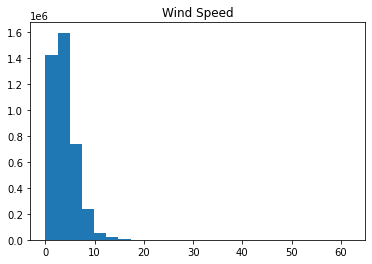

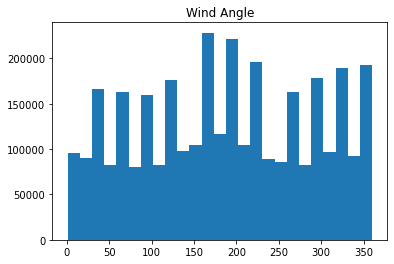

In [0]:
# summaries
display(weather_2015.select('WND_ANGLE').describe())
display(weather_2015.select('WND_SPEED').describe())

# histograms
weather_wind_speed = list(weather_2015.select('WND_SPEED').toPandas()['WND_SPEED'])
plt.hist(weather_wind_speed, bins = 25)
plt.title("Wind Speed")
display(plt.show())

weather_wind_angle = list(weather_2015.select('WND_ANGLE').toPandas()['WND_ANGLE'])
plt.hist(weather_wind_angle, bins = 25)
plt.title("Wind Angle")
display(plt.show())

#### Sky Condition (SKY_COND)

The sky condition variable contains a value for sky condition, which represents the height above ground level of the lowest cloud or obscuring phenomena layer aloft, as well as the quality score. In addition, there is a variable for 'CAVOC', which is the 'Ceiling and Visibility Okay' condition. CAVOC is a weather status report for pilots when visibility is at least 10 kilometres, there are no clouds below 5000 feet or minimum sector altitude (whichever is higher), and there is no current or forecast significant weather such as precipitation. All missing values labeled 9999 were converted to nulls. There are 14,348 missing values for sky condition and 20,334 bad quality values for sky condition. Most CAVOC values are N for No, meaning the ceiling and visibility was not ok for most observations. There is not a single observation with a value of yes, which seems odd. The sky condition value ranges from 0 to 22,000, with an average of about 11,800. There appear to be two clusters: those that range from 0 to 10,000, and then those over 20,000.

summary,SKY_COND
count,4050274
mean,11810.495328957992
stddev,10293.371055703841
min,0
max,22000


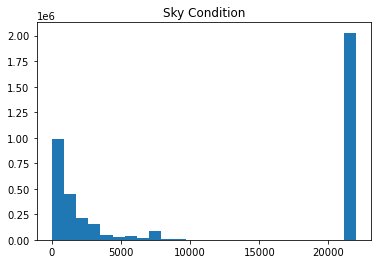

In [0]:
# summary
display(weather_2015.select('SKY_COND').describe())

# histogram
weather_sky_cond = list(weather_2015.select('SKY_COND').toPandas()['SKY_COND'])
plt.hist(weather_sky_cond, bins = 25)
plt.title("Sky Condition")
display(plt.show())

#### Temperature (TMP)

The temperature variable is given in Celcius and scaled by 10. Like the other variables, it also has a quality score. We separated the two into two separate fields and scaled the temperature score back to the raw value. We also changed any temperature records with an erroneous quality score to None and converted 9999s to null, so they did not affect our analysis. The temperature ranged from -41.7 to 47.2 degrees Celcius and the mean was 13 degrees celcius. The distribution of temeratures appears rather normal, with a slight left skew.

summary,TMP_CLEAN
count,4067885
mean,13.004994266061756
stddev,11.632010654705123
min,-41.7
max,47.2


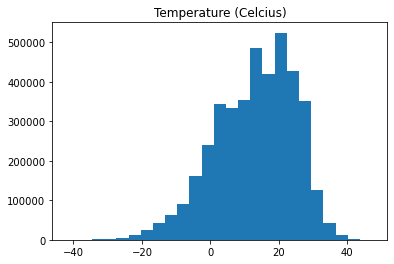

In [0]:
# summary 
display(weather_2015.select('TMP_CLEAN').describe())

# histogram
weather_temp = list(weather_2015.select('TMP_CLEAN').toPandas()['TMP_CLEAN'])
plt.hist(weather_temp, bins = 25)
plt.title("Temperature (Celcius)")
display(plt.show())

#### Visibility (VIS)

Another metric found in the weather data is visibility. This is the distance at which an object can be seen. Thus, a higher visibility value may result in a higher chance of delay. We removed any "erroneous" and missing values labeled 999, and found that visibility ranges from 0 meters to 160,000 meters. The data was capped at 160,000, so any observations higher than this were automatically set to 160,000. The mean visibility distance was about 14,000 meters. Most observations stayed under 20,000 meters.

summary,VIS_CLEAN
count,4077591
mean,14015.901565164333
stddev,4865.10481759854
min,0
max,160000


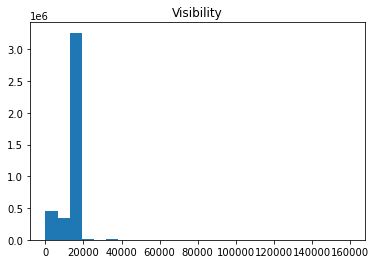

In [0]:
# summary
display(weather_2015.select('VIS_CLEAN').describe())

# histogram
weather_vis = list(weather_2015.select('VIS_CLEAN').toPandas()['VIS_CLEAN'])
plt.hist(weather_vis, bins = 25)
plt.title("Visibility")
display(plt.show())

#### Pressure (SLP and MA1)

Atmospheric pressure, also known as barometric pressure, is the pressure within the atmosphere of the earth. These measurements were taken at sea level. At higher altitudes, with a decreased atmospheric pressure, takeoff and landing distances are increased, while climb rates decrease. The SLP pressure was once again scaled by 10, so we divided our observations by 10, and as usual changed erroneous observations to null and 999s to null. The mean atmospheric pressure was about 1016 hecopascals. This is consistent with the global average of 1013. It ranged from 939 to 1057 hecopascals, and the distribution appears very normal. We noticed there was another column in the dataset that also signified pressure. This was MA1. The variable description for MA1 is what the aircraft pressure is set to, while SLP is what the actual pressure is. Comparing these two variables, the mean difference was 0.3 and the maximum difference was only 20 hectopascals off. Thus, we made a new variable called PRESSURE that coalesed SLP and MA1. The new PRESSURE variable was much more complete.

summary,PRESSURE
count,4079086
mean,1016.4291999726656
stddev,7.608882591462195
min,939.4
max,1056.9


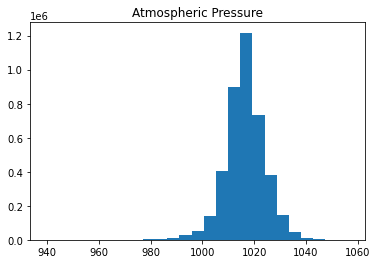

In [0]:
# summary
display(weather_2015.select('PRESSURE').describe())

# histogram
weather_pressure = list(weather_2015.select('PRESSURE').toPandas()['PRESSURE'])
plt.hist(weather_pressure, bins = 25)
plt.title("Atmospheric Pressure")
display(plt.show())

#### Humidity and Hazy Condictions (DEW, HUMID_DIFF, HIGH_CHANCE_THUNDER, and FOG)

Dew point temperature, also measured in celcius, is the temperature to which a given parcel of air must be cooled at constant pressure and water vapor content in order for saturation to occur. The dew point in relation to temperature gives pilots information about the humidity, and can affect visbility. If the dew point is close to the temperature, humidity is high, which can cause hazy conditions, or even fog. After erroneous and missing data was converted to null, we see that the dew temperature ranged from -39 to 29 degrees celcius. The mean was about 7, and the distribution appears left skewed. 

Because temperature and dew are so related and indicative of weather characteristics, we created a new variable called HUMID_DIFF, which was the difference between the temperature and the dew. HUMID_DIFF is always positive because the dew point temperature can never be higher than the actual temperature. 

High dew points correlate well with the probability and severity of thunderstorms. We created the variable HIGH_CHANCE_THUNDER as a binary variable based on whether the dew point was above 21 degrees celcius. In addition, fog forms when the difference between air temperature and dew point is generally less than 2.5 °C, so FOG was created as a binary variable as well. There were few weather observations with high chance thunder, and about 40% of observations with fog.

summary,DEW_CLEAN
count,4061558
mean,6.879707146862651
stddev,11.140493835422406
min,-39.0
max,29.0


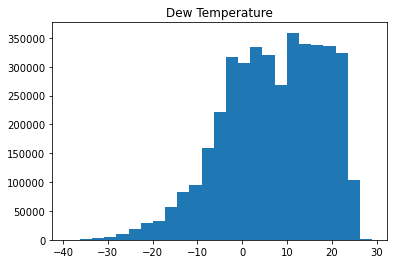

summary,HUMID_DIFF
count,4061307
mean,5.79629414865707
stddev,6.103305023474475
min,0
max,65


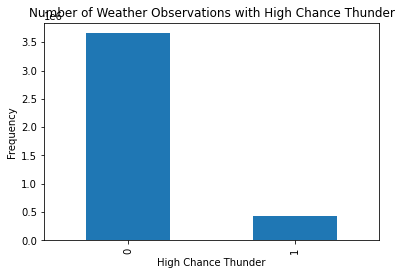

Thunder Value Counts
0 3656294
1 428662
Name: HIGH_CHANCE_THUNDER, dtype: int64

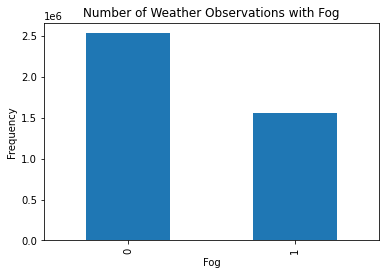

Fog Value Counts
0 2530708
1 1554248
Name: FOG, dtype: int64

In [0]:
# Dew
display(weather_2015.select('DEW_CLEAN').describe())

weather_dew = list(weather_2015.select('DEW_CLEAN').toPandas()['DEW_CLEAN'])
plt.hist(weather_dew, bins = 25)
plt.title("Dew Temperature")
display(plt.show())

#Humid Diff
display(weather_2015.select('HUMID_DIFF').describe())

# High chance Thunder
vc = weather_2015.select('HIGH_CHANCE_THUNDER').toPandas()['HIGH_CHANCE_THUNDER'].value_counts()
ax = vc.plot(kind='bar',
                                    title="Number of Weather Observations with High Chance Thunder")
ax.set_xlabel("High Chance Thunder")
ax.set_ylabel("Frequency")
plt.show()

print("Thunder Value Counts")
print(vc)

# Fog
vc = weather_2015.select('FOG').toPandas()['FOG'].value_counts()
ax = vc.plot(kind='bar',
                                    title="Number of Weather Observations with Fog")
ax.set_xlabel("Fog")
ax.set_ylabel("Frequency")
plt.show()

print("Fog Value Counts")
print(vc)

#### Significant Weather and Precipitation (SIG_WEATHER, PRECIPITATION)

**AW1** through **AW5** are variables in the additional column section contain codes that indicate significant weather. Although each variable **AW1** through **AW5** was rather sparse on its own, combining them together creates a better view. We went through and manually mapped any significant weather codes to the new binary variable we created called **SIG_WEATHER**. 20% of weather observations had significant weather. We also used these codes to create a new variable called **PRECIPITATION**, a cetegorical variable with 3 categories: None, Heavy, Slight or Moderate. Only 35,667 observations had heavy precipitation, 449,245 had slight or moderate, and the rest had None.

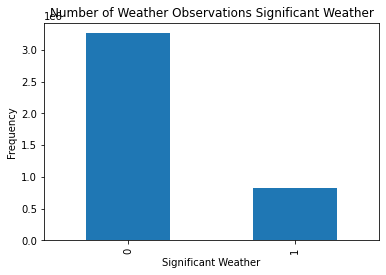

Significant Weather Value Counts
0 3258965
1 825991
Name: SIG_WEATHER, dtype: int64

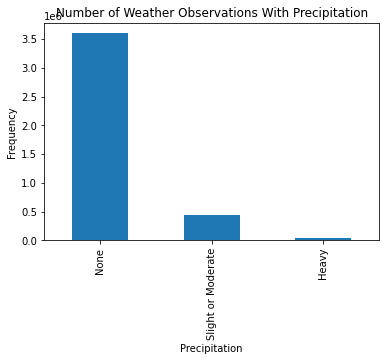

Precipitation Value Counts
None 3600044
Slight or Moderate 449245
Heavy 35667
Name: PRECIPITATION, dtype: int64

In [0]:
# Significant Weather
vc = weather_2015.select('SIG_WEATHER').toPandas()['SIG_WEATHER'].value_counts()
ax = vc.plot(kind='bar',
                                    title="Number of Weather Observations Significant Weather")
ax.set_xlabel("Significant Weather")
ax.set_ylabel("Frequency")
plt.show()

print("Significant Weather Value Counts")
print(vc)

# Precipitation

vc = weather_2015.select('PRECIPITATION').toPandas()['PRECIPITATION'].value_counts()
ax = vc.plot(kind='bar',
                                    title="Number of Weather Observations With Precipitation")
ax.set_xlabel("Precipitation")
ax.set_ylabel("Frequency")
plt.show()

print("Precipitation Value Counts")
print(vc)

#### Addition Columns for Weather Observations (AU) and Precipitation (AA)

The AU column in the weather dataset contains categorical information on weather events, including event intensity and descriptions (e.g., rain, snow, showers, thunderstorms, funnel cloud, etc.). The data from this column was extracted into four categorical columns: **WTR_INTENSITY**, **WTR_DESC**, **WTR_PRECIP**, **WTR_OBSC**, and **WTR_OTR**.

The AA column contains information on the amount of precipitation, in millimeters, that has fallen over a specified time period. We created two columns with this data: **PRECIP_PER**, which specifies the number of hours over which the precipitation fell, and **PRECIP_QTY**, which is the number of millimeters of precipitation. If the precipitation period exceeded one hour, the columns are set to NULL because the data may not be indicative of current weather conditions.

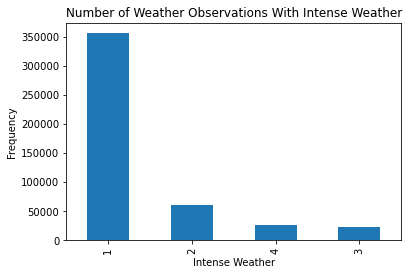

Intense Weather Value Counts
1 355497
2 60006
4 25895
3 22597
Name: WTR_INTENSITY, dtype: int64

summary,PRECIP_QTY
count,2742316
mean,2.1903183294704185
stddev,13.743818055192445
min,0
max,1463


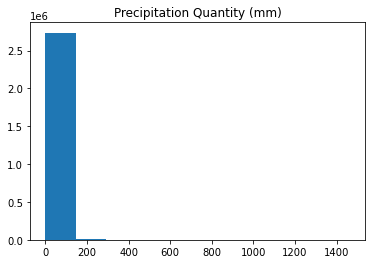

In [0]:
# Weather Intensity
vc = weather_2015.select('WTR_INTENSITY').toPandas()['WTR_INTENSITY'].value_counts()
ax = vc.plot(kind='bar',
                                    title="Number of Weather Observations With Intense Weather")
ax.set_xlabel("Intense Weather")
ax.set_ylabel("Frequency")
plt.show()

print("Intense Weather Value Counts")
print(vc)

# Precipitation Quantity

display(weather_2015.select('PRECIP_QTY').describe())

weather_dew = list(weather_2015.select('PRECIP_QTY').toPandas()['PRECIP_QTY'])
plt.hist(weather_dew)
plt.title("Precipitation Quantity (mm)")
display(plt.show())

### Joining the Data Flights and Weather Data

In order to join the weather and flights data, the first thing we wanted to make sure is that our day time fields were showing in the same time zone. That is why we went back and converted our flight times to UTC. We used a helper IATA -> ICAO dataset to map station codes to flights & weather data. At that point, the weather data had a field for airport location similar to the ORIGIN and DEST fields in the flight data. Because we were tasked with predicting a delay 2 hours before and we did not have weather for every minute of every day, we decided to round our day times to day hour, in both weather and flight data. We created a combined column of location and day hour for our join column. On the flight dataset, we created this column based on 2 hours before the flight departure. This column looks like this: <br><img width="50%" src='https://raw.githubusercontent.com/FrankYFTang/images/main/join2.png'>

Once we created this column in our weather data, we also removed duplicates using this column, as there would have been more than 1 weather report per hour per location, but we only needed one. We considered looking for a way to find the most "important" or "dramatic" weather point for each hour in each location, but we determined that if a weather condition lasted for less than an hour, it probably wouldnt affect the flight too much. We determined that this would be something we would want to do in future work.

We joined the weather on the departure join column first, creating a dataset with the same amount of rows as the original airport data, but with added columns with weather conditions. We then decided it would be important to see the arrival weather as well. We created a temporary dataframe with all the same weather columns, but with an "arr" suffix so we could distinguish between departure and arrival weather. At first, we considered just joining the weather data on the predicted arrival time since weather is often forecasted in the future. However, we determined that we could make the assumption that temperature could be forecasted, but we could not make the assumption that other very detailed fields could be forecasted. Thus, we joined the weather data on the flight data again in the same way, 2 hours before departure time, but this time on arrival location.

### Encode Categorical Variables into Numeric Values
To properly handle categorical variables without greatly expanding the dimension, we avoid the use of *one-hot encoding*, which will expand each value in a categorical variable into a new dimension:
* Use **Weight of Evidence** encoder to encode most categorical unless there are some special way we can better represent the categorical, as noted below.
* Use **PageRank** of an airport to encode the **ORIGIN** and **DEST**.

#### Weight of Evidence Encoder
We implemented "Weight of Evidence" encoder **WOEEncoder** in the [Encoder notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4377823981612210/command/4377823981616147).  We then use the WOEEncoder to encode most of the categorical variables except some specific one we believe we can use different methods to handle them better. This approach replaced the OneHotEncoder in our first attempt and dramatically reduced the dimension explosion and avoided overfitting. The "Weight of Evidence" is caculated as 
<img src ='https://miro.medium.com/max/1257/1*w4daAYWMcLGBBEhK3JB4Tw.png'>. The formula of WoE is as such:
For each class i of an independent variable x, we want to find the ratio of the proportion/percentage of the population, whose dependent variable y belongs to a certain class, that has the class i, followed by natural log. (Ref ["Model? Or do you mean Weight of Evidence (WoE) and Information Value (IV)?""](https://towardsdatascience.com/model-or-do-you-mean-weight-of-evidence-woe-and-information-value-iv-331499f6fc2)). We have also implemented **TargetEncoder** and **LeaveOneOutEncoder** in that ["Encoder notebook"](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4377823981612210/command/4377823981616147) but we believe using **WOEEncoder** would be a better choice.

#### Variable Transformation

In order to remove anomalies and outliers from our data, we transformed all of our variables (including categorical variables after they were encoded uses weight of evidence) by normalizing. To do this, we removed the mean and scaled each variable to unit variance. More on this can be found in section 5, as it it model-dependent.

# __Section 4__ - Algorithm Exploration

To predict delayed flights, we experimented with **Logistic Regression**, **Random Forests**,  **Gradient Boosted Trees** and **XGBoost**. We also implemented Cross-Validation on Logistic Regression.

### Toy Example - Logistic Regression

To illustrate how Spark and parallel processing can be used for machine learning, we will create a toy logistic regression model with a handful of features from the flight and weather data. We will train the model on one day of flight data and test the model with flight data from a different day.

#### Model Description
Logistic regression is a machine learning technique that can be used with binary or categorical outcomes. Logistic regression differs from linear regression in that the dot product of the features and weights is passed to a logit function:

$$ \textrm{logit}(x) = \frac{e^x}{1 + e^x}$$

There are two other significant differences between linear regression and logistic regression.
1. Instead of choosing weights that minimize the residual sum of squares, we attempt to maximize the log likelihood in logistic regression. In other words, we choose weights that maximize the likelihood of observing the actual data.
2. There is no closed-form solution for identifying the weights that maximize the log likelihood. Instead, we create a cost function that will be minimized with the same weights that maximize the log likelihood. Finally, we use gradient descent to identify the weights that minimize the cost function.

[The full derivation of the likelihood, cost, and gradient update equations is available here.](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4151209294143483/command/4151209294143484) Our notation and key equations listed below.

##### Notation
\\(y_i\\) is our dependent variable, equal to 1 if a flight is delayed and 0 if the flight is on time.

The features for flight \\(i\\) are represented by the vector \\(x_i\\).  
* The individual features of \\(x_i\\) are indicated by the index \\(j\\).
* Therefore \\(x_{i, j}\\) is the \\(j\\)-th feature of flight \\(i\\).
* To simplify the equations, \\(x_i\\) is augmented, with \\(x_0 = 1\\)
* There are \\(N\\) observations.

The weights are represented by the vector \\(w\\), with the intercept equal to \\(w_0\\). \\(p\\) is the number of features, so \\(x_i\\) and \\(w\\) have length \\(p+1\\). The index \\(j\\) is used to indicate the feature. \\(f(x_i)\\) is the logistic regression function that predicts \\(y\\) from \\(x_i\\). The learning rate is \\(\alpha\\) and the ridge regression parameter is \\(\lambda\\).

##### Logistic Regression Equation
$$ f(x_i) = \frac{e^{w^Tx_i}}{1 + e^{w^Tx_i}} $$

##### Log Likelihood Function:
$$ l = \sum_i^N \left[ y_i \ln(f(x_i)) + (1 - y_i)\ln(ln(1 - f(x_i))) \right]  $$

##### Cost Function with Ridge Regression:
$$ J = - \frac{1}{N} \sum_i^N \left[ y_iw^Tx_i - \ln(1 + e^{w^Tx_i}) \right] + \lambda w^Tw $$

##### Gradient Equation:
$$ \frac{\partial J}{\partial w_j} = \frac{1}{N} \sum_i^N \left[ (f(x_i) - y_i) x_{i,j} \right] + \lambda w_j$$

##### Gradient Update:
$$w = w - \alpha \frac{1}{N} \sum_i^N \left[ (f(x_i) - y_i) x_i \right] + \lambda w$$

#### Load Datasets
Our toy training dataset will be a Thursday in the middle of January 2015. Our toy test dataset will be the following Thursday.

In [0]:
train_df = (
  joined_data_2015
  .where(f.col("FL_DATE") == '2015-01-15')
   # Assume maximum visibility if value is NULL
  .fillna(16000, "VIS_CLEAN")
  # Zeros are appropriate for all other NULLs.
  .fillna(0)
  .coalesce(10)
  .cache()
)

test_df = (
  joined_data_2015
  .where(f.col("FL_DATE") == '2015-01-22')
  .fillna(16000, "VIS_CLEAN")
  .fillna(0)
  .coalesce(10)
  .cache()
)

#### Prepare Data
Our data is currently contained in Spark dataframes. The following function will convert the dataframe into an resilient distributed dataset (RDD) with the features combined into a numpy array. The numeric features will be scaled by subtracting the mean and dividing by the standard deviation of each feature. The means and standard deviations that are extracted from the training dataset will be applied to the test data.

In [0]:
def generate_scaled_rdd(df, predicted, numeric_features, binary_features,
                        means = None, sdevs = None):
  """Converts a Spark dataframe to an RDD with scaled features
  
  Args:
    df: A Spark dataframe
    predicted: String, the name of the column with the predicted
      variable
    numeric_features: [String], A list of column names with
      numeric data. These columns will be scaled by subtracting
      the mean and dividing by the standard deviation.
    binary_features: [String], A list of column names with
      binary features, either 0 or 1. These columns will be left
      unchanged.
    means, sdevs: A list containing the mean or standard deviation
      of each column. The means and standard deviations must be
      the same length as, and in the same order as the
      numeric_features column. Optional. If absent, this
      function will calculate the means and deviations from
      the dataframe (for training data). These parameters allow
      the means and standard deviations that were calculated from
      the training data to be applied to the test data.
      
  Returns: A pair RDD, with the first element is the predicted
  value and the second element is a numpy array of the features.
  """
  
  # Transform separate columns into vectors
  num_numeric_features = len(numeric_features)
  
  vect_assembler_numeric = VectorAssembler(outputCol="numeric_features")
  vect_assembler_numeric.setInputCols(numeric_features)
  df = vect_assembler_numeric.transform(df)
  
  vect_assembler_binary = VectorAssembler(outputCol="binary_features")
  vect_assembler_binary.setInputCols(binary_features)
  df = vect_assembler_binary.transform(df)
  
  unscaled_rdd = (
    df
    .select(predicted, "binary_features", "numeric_features")
    .rdd
    .map(lambda x: (x[predicted],
                    x["binary_features"].toArray(),
                    x["numeric_features"].toArray()))
    .cache()
  )
  
  # Calculate means and deviations if not passed as params
  if means is None or sdevs is None:
    means = [unscaled_rdd.map(lambda x: x[2][col]).mean()
             for col in range(num_numeric_features)]
    sdevs = [unscaled_rdd.map(lambda x: x[2][col]).stdev()
             for col in range(num_numeric_features)]
  bc_means = sc.broadcast(means)
  bc_sdevs = sc.broadcast(sdevs)
  
  # Scale numeric features with means and deviations
  def scale_numeric_features(features):
    return np.array([(features[i] - bc_means.value[i]) / bc_sdevs.value[i]
                     for i in range(num_numeric_features)])
  
  scaled_rdd = (
    unscaled_rdd
    .map(lambda x: (int(x[0]),
                    np.concatenate(
                      [[1], x[1], scale_numeric_features(x[2])],)))
    .cache()
  )
  
  return scaled_rdd, means, sdevs

In [0]:
# Generate train and test RDDs with scaled numeric features
# RDD Format: (y, np.array(1, x_1, x_2, ...))
train_rdd, means, sdevs = generate_scaled_rdd(
  train_df,
  "DEP_DEL15_NN",
  ["AVG_ORIGIN_DELAY", "AVG_DEST_DELAY", "DEST_PR", "PRIOR_DEP_DELAY", "VIS_CLEAN"],
  ["PRIOR_DEL15", "SIG_WEATHER"])

test_rdd = generate_scaled_rdd(
  test_df,
  "DEP_DEL15_NN",
  ["AVG_ORIGIN_DELAY", "AVG_DEST_DELAY", "DEST_PR", "PRIOR_DEP_DELAY", "VIS_CLEAN"],
  ["PRIOR_DEL15", "SIG_WEATHER"],
  means, sdevs)[0]

#### Logistic Regression and Gradient Descent
The following functions implement the logistic regression algorithm with gradient descent and are developed from the logistic regression equations presented at the beginning of section 4. The algorithm is parallelized by having different executors calculate different elements of the sum, and then summing the elements in the reduction phase. These functions use ridge regression.

In [0]:
def calc_grad(data_rdd, N, weights, reg=0.001):
  """Calculates the gradient for logistic regression.
  
  Uses ridge regularization.
  
  Args:
    data_rdd: An RDD with test data, in the format
      (y, np.array([1, x_1, x_2, ...]))
    N: Length of RDD
    weights: Current weights as an numpy array.
      Must be the same length as the feature array
      in the RDD.
    reg: regularization parameter for ridge regression.
      Optional. Defaults to 0.001.
      
  Returns: Gradient, as a floating point value.
  """
  bc_w = sc.broadcast(weights)
  
  # Emits one term from the gradient equations summation term.
  def emit_grad_term(flight):
    y = flight[0]
    x = flight[1]
    w = bc_w.value
    z = math.exp(np.dot(x, bc_w.value))
    y_hat = z / (1 + z)
    return (y_hat - y) * x
  
  sum_term = (
    data_rdd
    .map(emit_grad_term)
    .reduce(lambda x, y: x + y) # Complete summation
  )
  # Complete gradient calculation
  return sum_term/N + reg * bc_w.value


def update_weights(data_rdd, N, weights, reg=0.001, alpha=0.0001):
  """New weights from one iteration of gradient descent.
  
  Args:
    alpha: Learning rate. Optional, defaults to 0.0001.
    other parameters: See docstring for calc_grad()
    
  Returns: weight vector as numpy array.
  """
  return weights - alpha * calc_grad(data_rdd, N, weights, reg)


def calc_cost(data_rdd, N, weights, reg=0.001):
  """Calculate cost based on log-likelihood function.
  
  Uses ridge regularization.
  
  Args: see docstring for calc_grad()
  
  Returns: cost as floating point value.
  """
  bc_w = sc.broadcast(weights)
  
  # Emits one term of the cost function's summation
  def emit_cost_term(flight):
    y = flight[0]
    x = flight[1]
    dot = np.dot(bc_w.value, x)
    term = y * dot - math.log(1 + math.exp(dot))
    return term
    
  # Calculate summation term from cost function
  cost_term = (
    data_rdd
    .map(emit_cost_term)
    .reduce(lambda x, y: x + y)
  )
  
  # Complete the cost calcuation (adding in ridge regresion)
  return -cost_term/N + reg * np.dot(bc_w.value, bc_w.value)

In [0]:
def iterate_grad_descent(data_rdd, initial_weights, iters=50,
                         rpt_freq=10, reg=0.001, alpha=0.0001):
  """Conducts multiple iterations of gradient descent.
  
  Args:
    data_rdd: An RDD with test data, in the format
      (y, np.array([1, x_1, x_2, ...]))
    initial_weights: Weights as an numpy array. Augmented,
      with first weight as intercept. Must be the same
      length as the feature array in the RDD.
    iters: Number of iterations. Optional, defaults to 50.
    rpt_freq: Number of iterations between status printouts.
    reg: regularization parameter for ridge regression.
      Optional. Defaults to 0.001.
    alpha: Learning rate. Optional. Defaults to 0.0001.
  """
  N = data_rdd.count()
  weights = initial_weights
  
  def status_printout(i=None):
    print()
    if i is not None:
      print("Iterations:", i)
    print("Weights:", weights)
    print("Cost:", calc_cost(data_rdd, N, weights, reg))
      
  status_printout()
  for i in range(1, iters + 1):
    weights = update_weights(data_rdd, N, weights, reg, alpha)
    if i % rpt_freq == 0:
      status_printout(i)

  status_printout()
  return weights

#### Train Model
To test our toy logistic regression model, we ran 400 iterations of gradient descent.

In [0]:
# Run 400 Iteations of gradient descent
# Initially tried setting initial weights to zero, but
#   cost jumped around and did not steadily decrease.
weights = iterate_grad_descent(train_rdd, np.ones(8),
                               iters=400, rpt_freq=20,
                               alpha = 0.02, reg = 0.1)

Weights: [1. 1. 1. 1. 1. 1. 1. 1.]
Cost: 2.203878341923174

Iterations: 20
Weights: [0.77158697 0.94835795 0.93698359 0.94228363 0.92096652 0.90312689
 0.9771724 0.9160281 ]
Cost: 1.926715826281568

Iterations: 40
Weights: [0.56349139 0.89905872 0.87776794 0.88554507 0.84424903 0.81103373
 0.95325093 0.83795468]
Cost: 1.6904080427545254

Iterations: 60
Weights: [0.37487233 0.85205325 0.82217671 0.82999209 0.77045679 0.72447332
 0.92839489 0.76564974]
Cost: 1.490568774247031

Iterations: 80
Weights: [0.20480045 0.80729682 0.77003176 0.77585179 0.70017077 0.64406856
 0.90278688 0.69894602]
Cost: 1.323003421518894

Iterations: 100
Weights: [0.0522489 0.76474771 0.72115202 0.72336273 0.63391107 0.57025508
 0.87663169 0.63763599]
Cost: 1.1836905697137394

Iterations: 120
Weights: [-0.08390564 0.72436539 0.67535345 0.67276332 0.57210604 0.50324281
 0.85015242 0.58147045]
Cost: 1.068797034884434

Iterations: 140
Weights: [-0.20486806 0.6861085 0.63245019 0.62427732 0.51506766 0.44300754
 0.82358344 0.53016125]
Cost: 0.9747220660808031

Iterations: 160
Weights: [-0.31189682 0.64993278 0.59225663 0.57809928 0.46297662 0.38931439
 0.79716094 0.48338862]
Cost: 0.8981548381210739

Iterations: 180
Weights: [-0.40626808 0.61578927 0.55459002 0.53438274 0.41587919 0.34176528
 0.77111255 0.44081229]
Cost: 0.8361255933433053

Iterations: 200
Weights: [-0.48923892 0.58362299 0.51927299 0.49323365 0.37369526 0.29985673
 0.74564794 0.40208403]
Cost: 0.7860360387285652

Iterations: 220
Weights: [-0.56201558 0.55337222 0.48613576 0.45470927 0.33623562 0.26303489
 0.72095144 0.36685948]
Cost: 0.7456641445026702

Iterations: 240
Weights: [-0.62572992 0.52496849 0.45501778 0.41882164 0.30322549 0.23073977
 0.69717755 0.33480775]
Cost: 0.7131465182226346

Iterations: 260
Weights: [-0.6814248 0.49833715 0.42576871 0.38554408 0.27433083 0.2024356
 0.67444892 0.3056181 ]
Cost: 0.6869453990111642

Iterations: 280
Weights: [-0.73004724 0.47339844 0.39824891 0.35481868 0.24918402 0.17762865
 0.65285668 0.27900401]
Cost: 0.6658076456291842

Iterations: 300
Weights: [-0.77244773 0.45006879 0.37232949 0.32656381 0.22740628 0.1558753
 0.63246231 0.25470478]
Cost: 0.6487216314912657

Iterations: 320
Weights: [-0.80938383 0.42826225 0.347892 0.30068057 0.20862517 0.13678354
 0.61330061 0.23248558]
Cost: 0.6348760536751183

Iterations: 340
Weights: [-0.84152631 0.40789195 0.32482795 0.27705807 0.19248682 0.12001055
 0.59538316 0.21213632]
Cost: 0.6236229548675283

Iterations: 360
Weights: [-0.86946667 0.38887137 0.30303812 0.25557727 0.17866341 0.10525838
 0.5787021 0.19346986]
Cost: 0.61444595450974

Iterations: 380
Weights: [-0.89372523 0.37111545 0.28243191 0.23611392 0.16685685 0.09226888
 0.5632337 0.17631991]
Cost: 0.6069338051629214

Iterations: 400
Weights: [-0.91475892 0.35454151 0.26292656 0.21854051 0.15679988 0.0808186
 0.54894172 0.16053888]
Cost: 0.600758871968535

Weights: [-0.91475892 0.35454151 0.26292656 0.21854051 0.15679988 0.0808186
 0.54894172 0.16053888]
Cost: 0.600758871968535

#### Training Results
With a learning rate of 0.02 and a ridge regression value of 0.1, we can see that loss decreased throughout the 400 iterations of gradient descent—quickly for the earlier iterations but slowing down later on. The weights are still shifting in value, but are relatively stable.

In [0]:
def get_predictions_rdd(test_rdd, weights):
  """Generates an RDD of predictions.
  
  Args:
    test_rdd: RDD with test data.
    weights: Final weights from logistic regression
      iterations.
      
  Returns: An RDD formatted as:
  (y, y_hat, probability, True Postive, True Negative,
    False Positive, False Negative)
  """
  bc_w = sc.broadcast(weights)
  
  def predict(flight):
    y = flight[0]
    x = flight[1]
    z = math.exp(np.dot(x, bc_w.value))
    p = z / (1 + z)
    y_hat = 1 if p >= 0.5 else 0
    
    TP, FP, TN, FN = False, False, False, False
    if y == 1 and y_hat == 1:
      TP = True
    elif y == 0 and y_hat == 1:
      FP = True
    elif y == 0 and y_hat == 0:
      TN = True
    else:
      FN = True
    
    return (y, y_hat, p, TP, TN, FP, FN)
  
  return (test_rdd
          .map(predict)
          .cache())

In [0]:
# Get predictions on test data
preds = get_predictions_rdd(test_rdd, weights)
preds.take(10)

Out[52]: [(0, 0, 0.25042911066085477, False, True, False, False),
 (0, 0, 0.2788140908838402, False, True, False, False),
 (0, 0, 0.27660794961854807, False, True, False, False),
 (0, 0, 0.22632863907041179, False, True, False, False),
 (0, 0, 0.2660158645908744, False, True, False, False),
 (0, 0, 0.2820993983984104, False, True, False, False),
 (0, 0, 0.3005650260843283, False, True, False, False),
 (0, 0, 0.2564139773404277, False, True, False, False),
 (0, 0, 0.2705916162780181, False, True, False, False),
 (0, 0, 0.27122677665779743, False, True, False, False)]

In [0]:
def get_metric_counts(preds_rdd):
  """Sums the metrics in a predictions RDD.
  
  Args:
    An RDD formatted as (y, y_hat, probability, True Postive,
    True Negative, False Positive, False Negative)
    
  Returns: A tuple containing the sum of true positives,
  true negatives, false positives, and false negatives.
    """
  counts = (
    preds_rdd
    .map(lambda x: (x[3], x[4], x[5], x[6]))
    .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
  )
  
  return counts
    
mc = get_metric_counts(preds)
mc

Out[53]: (542, 13369, 451, 1730)

In [0]:
accuracy = (mc[0] + mc[1]) / sum(mc)
print(f"Accuracy:\t{accuracy:.3f}")

recall = mc[0] / (mc[0] + mc[3])
print(f"Recall:\t\t{recall:.3f}")

precision = mc[0] / (mc[0] + mc[2])
print(f"Precision:\t{precision:.3f}")

f1 = 2 * recall * precision / (recall + precision)
print(f"F1 Score:\t{f1:.3f}")

Accuracy:	0.864
Recall: 0.239
Precision:	0.546
F1 Score:	0.332

#### Test Performance
The accuracy is slightly better than what would be achieved by a naive model that always predicts on-time flights: 87.3% vs. a 83.6% on-time rate in the test data. Recall is low, with only 17.0% of delayed flights recognized. This drives the F1 score down to 0.274. We have a few options for improving this model's performance:
1. Since this is a demonstration model, we did little hyperparameter tuning. It's possible that different values of the regularization parameter would improve performance.
2. Our probability threshold for predicting a delayed flight is 0.5. Lowering this probability threshold would improve recall at the cost of precision. Evaluating the receiving operating characteristics curve would help to evaluate the effect of changing the probability threshold.
3. The imbalanced dataset is likely contributing to the low recall. Since only 16.4% of flights are delayed, the cost function is minimized by predicting a high proportion of on-time flights. Imbalance could be addressed by over-sampling delayed flights, or weighting the cost function such that false negatives incur higher cost.

## Baseline Models
Our original baseline model was based on Spark MLLib's distribution of Logistic Regression, using the 6-month dataset. Training and testing sets were randomly split based on the week_of_year column. Thus, flights that belonged under the same day would not be seen by both training and testing sets. The datasets are identical to the joined dataset presented in section 2, except that their categorical variables have been encoded using the weight of evidence (WOE) technique. [The WOE code is in this notebook.](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/528073926734987/command/37954262501289)

In [0]:
FILE_PATH = '/Users/juliantsang@berkeley.edu/final_project/'
baseline_train = spark.read.option("header", "true").parquet(FILE_PATH+"train_woe_encoded_pipelined_baseline_04092021.parquet").cache()
baseline_test = spark.read.option("header", "true").parquet(FILE_PATH+"test_woe_encoded_pipelined_baseline_04092021.parquet").cache()

### Logistic Regression

In [0]:
lr = LogisticRegression(labelCol = "label", featuresCol="Scaled_features", weightCol="classWeights") 
model=lr.fit(baseline_train)
predict_train=model.transform(baseline_train)
predict_test=model.transform(baseline_test)

y_true = predict_test.select(['label']).collect()
y_pred = predict_test.select(['prediction']).collect()

print(classification_report(y_true, y_pred, digits=4))

evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(predict_test)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(predict_test, {evaluator.metricName: 'areaUnderPR'})))

precision recall f1-score support

 0.0 0.9179 0.3304 0.4859 34603
 1.0 0.2196 0.8645 0.3502 7542

 accuracy 0.4260 42145
 macro avg 0.5688 0.5974 0.4181 42145
weighted avg 0.7930 0.4260 0.4616 42145

The area under ROC for train set is 0.7494
The area under ROC for test set is 0.6961
Test Area Under Precision-Recall Curve: 0.3757

In [0]:
numeric_metadata = predict_train.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
coef = model.coefficients

weights_arr = []
feature_arr = []

for index in numeric_metadata:
  idx = (index['idx'])
  weights_arr.append(float(coef[idx]))
  feature_arr.append(index['name'])

weightsDF = sqlContext.createDataFrame(zip(feature_arr,weights_arr), schema=['feature', 'weight'])
weightsDF.sort("weight", ascending=False).toPandas()

Out[5]:

,feature,weight
0,AVG_ORIGIN_DELAY,0.372152
1,ORIGIN_woe_encoded,0.134940
2,MONTH,0.105415
3,AVG_DEST_DELAY,0.071825
4,CT_DEL15,0.039781
5,DISTANCE,0.035554
6,WND_ANGLE,0.023874
7,WND_SPEED,0.022660
8,FOG_woe_encoded,0.018992
9,DAY_OF_WEEK,0.002831


### Logistic Regression with Cross Validation
We perform Cross Validation with hyperparameter tuning on the 6-Month Dataset.

[Parameters](https://spark.apache.org/docs/latest/api/java/index.html?org/apache/spark/ml/classification/LogisticRegression.html) include:
- maxIter - maximum number of iterations
- regParam - regularization parameter
- elasticNetParam - ElasticNet parameter for regularization. 
  - if alpha = 0 -> L2 penalty (ridge regression)
  - if alpha = 1 -> L1 penalty (lasso regression)
  - if alpha in between 0 and 1, uses both

In [0]:
lr = LogisticRegression(labelCol = "label", featuresCol="Scaled_features", weightCol="classWeights", maxIter=100, regParam=0.01) 
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1, 2])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1])
             .addGrid(lr.maxIter, [10,20,50,100])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5, parallelism=5)

cvModel = cv.fit(baseline_train)
predictions = cvModel.bestModel.transform(baseline_test)

lr_cv_Model_train = cvModel.bestModel.transform(baseline_train)
lr_cv_Model_predictions = cvModel.bestModel.transform(baseline_test)

y_true = lr_cv_Model_predictions.select(['label']).collect()
y_pred = lr_cv_Model_predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred, digits=4))

evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(lr_cv_Model_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(lr_cv_Model_predictions)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(lr_cv_Model_predictions, {evaluator.metricName: 'areaUnderPR'})))

best_model = cvModel.bestModel
print('Best Param (regParam):', best_model.getRegParam())
print('Best Param (maxIter):', best_model.getMaxIter())
print('Best Param (elasticNetParam):', best_model.getElasticNetParam())

cvModel.bestModel.write().overwrite().save(FILE_PATH + "LR_MODEL_CV_04102021_regParam_maxIter_elasticNetParam")

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
 precision recall f1-score support

 0.0 0.9234 0.2765 0.4255 34603
 1.0 0.2123 0.8947 0.3432 7542

 accuracy 0.3871 42145
 macro avg 0.5678 0.5856 0.3844 42145
weighted avg 0.7961 0.3871 0.4108 42145

The area under ROC for train set is 0.7491
The area under ROC for test set is 0.6971
Test Area Under Precision-Recall Curve: 0.3759
Best Param (regParam): 0.01
Best Param (maxIter): 100
Best Param (elasticNetParam): 0.0

In [0]:
numeric_metadata = lr_cv_Model_train.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
coef = cvModel.bestModel.coefficients

weights_arr = []
feature_arr = []

for index in numeric_metadata:
  idx = (index['idx'])
  weights_arr.append(float(coef[idx]))
  feature_arr.append(index['name'])

weightsDF = sqlContext.createDataFrame(zip(feature_arr,weights_arr), schema=['feature', 'weight'])
weightsDF.sort("weight", ascending=False).toPandas()

Out[57]:

,feature,weight
0,AVG_ORIGIN_DELAY,0.335189
1,ORIGIN_woe_encoded,0.086377
2,AVG_DEST_DELAY,0.074501
3,MONTH,0.056032
4,CT_DEL15,0.046584
5,DISTANCE,0.033864
6,WND_SPEED,0.025330
7,WND_ANGLE,0.019967
8,FOG_woe_encoded,0.017426
9,DAY_OF_WEEK,-0.000357


When we initially run **Logistic Regression** on the 6-Month dataset, we obtain a Delay F1-Score of 0.3502. Thus, the baseline model has poor performance in identifying delays. After performing 5-fold cross-validation with hyperparameter tuning, we obtain a Delay F1-Score 0.3425. However, these low scores aren't representative of the dataset since we are only using 6-months.

Computing feature importance for this model provided some guidance on both feature selection and feature engineering. Not only do we see which features were potentially predictive of delays, but also which features can be elaborated upon. Features with positive weights were correlated with non-delays and features with negative weights were correlated with delays. Upon examining the three greatest negative coefficients, **DEP_TIME_BLK**, **FL_DATE**, and **TAIL_NUM**, we decided to create new features that would be related to date/time or the aircraft tail number. In particular, we created a new week_of_year feature that would be indicative of some type of seasonality of any given year. We also created new features that would allow us to capture the delay state of a particular **TAIL_NUM**: **PRIOR_DEL15** and **PRIOR_DEP_DELAY**. These new features improved performance of our models moving forward in Section 5. To our surprise, we found that weather-related features did not have weights as high in magnitude as the flight features.

Next, we implemented more sophisticated ensemble tree-based models like **Random Forests**, **Gradient Boosted Trees**, and **XGBoost** on the 6-Month dataset to see if there were any baseline performance gains.

### Random Forest
Below is the result of the baseline run of 6-Month dataset with **Random Forest** for exploratory purposes only. A more detailed explanation about the **Random Forest** algorithm and more careful analysis would be presented in later sections of this notebook.

In [0]:
rf = RandomForestClassifier(labelCol="label", featuresCol="Scaled_features", weightCol="classWeights")
rf_Model = rf.fit(baseline_train)
rf_train = rf_Model.transform(baseline_train)
rf_predictions = rf_Model.transform(baseline_test)

evaluator = BinaryClassificationEvaluator()
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(rf_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(rf_predictions)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(rf_predictions, {evaluator.metricName: 'areaUnderPR'})))

y_true = rf_predictions.select(['label']).collect()
y_pred = rf_predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred, digits=4))

The area under ROC for train set is 0.7379
The area under ROC for test set is 0.6943
Test Area Under Precision-Recall Curve: 0.3826
 precision recall f1-score support

 0.0 0.9113 0.3901 0.5463 34603
 1.0 0.2278 0.8258 0.3572 7542

 accuracy 0.4680 42145
 macro avg 0.5696 0.6079 0.4517 42145
weighted avg 0.7890 0.4680 0.5124 42145

### Gradient Boosted Trees
Below is the result of the baseline run of 6-Month dataset with **Gradient Boosted Trees** for exploratory purposes only. Detailed explanation about the **Gradient Boosted Trees** algorithm and more careful analysis would be presented in later sections of this notebook.

In [0]:
gbt = GBTClassifier(labelCol = "label", featuresCol="Scaled_features", weightCol="classWeights")
GBT_Model = gbt.fit(baseline_train)
gbt_train = GBT_Model.transform(baseline_train)
gbt_predictions = GBT_Model.transform(baseline_test)

evaluator = BinaryClassificationEvaluator()
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(gbt_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(gbt_predictions)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'areaUnderPR'})))

y_true = gbt_predictions.select(['label']).collect()
y_pred = gbt_predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred, digits=4))

The area under ROC for train set is 0.7592
The area under ROC for test set is 0.6938
Test Area Under Precision-Recall Curve: 0.3845
 precision recall f1-score support

 0.0 0.9046 0.4395 0.5916 34603
 1.0 0.2344 0.7873 0.3612 7542

 accuracy 0.5017 42145
 macro avg 0.5695 0.6134 0.4764 42145
weighted avg 0.7847 0.5017 0.5504 42145

### XGBoost
Below is the result of the baseline run of 6-Month dataset with **XGBoost** for exploratory purposes only. Detailed explanation about the **XGBoost** algorithm and more careful analysis would be presented in later sections of this notebook.

In [0]:
xgb_classifier = XGBoostClassifier(labelCol="label", featuresCol="Scaled_features", weightCol="classWeights", treeMethod="hist", 
                                   missing=0.0, nthread=1, numWorkers=16) #


xgb_model = xgb_classifier.fit(baseline_train)
xgb_train = xgb_model.transform(baseline_train)
xgb_predictions = xgb_model.transform(baseline_test)

evaluator = BinaryClassificationEvaluator()
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(xgb_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(xgb_predictions)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(xgb_predictions, {evaluator.metricName: 'areaUnderPR'})))

y_true = xgb_predictions.select(['label']).collect()
y_pred = xgb_predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred, digits=4))

The area under ROC for train set is 0.7385
The area under ROC for test set is 0.6692
Test Area Under Precision-Recall Curve: 0.3665
 precision recall f1-score support

 0.0 0.8828 0.6331 0.7374 34603
 1.0 0.2674 0.6143 0.3726 7542

 accuracy 0.6298 42145
 macro avg 0.5751 0.6237 0.5550 42145
weighted avg 0.7727 0.6298 0.6721 42145

## Baseline Model Summary

| Model                    | Test AUC    | Test AUPRC  | Non-Delay F1 | Delay F1 | Training and Evaluation Time |
| -----------              | ----------- | ----------- | -----------  | -------- | ------------- |
| Logistic Regression      | 0.6961      | 0.3757      | 0.4859       | 0.3502   | 10.87 seconds |
| Logistic Regression (CV) | 0.6971      | 0.3758      | 0.4217       | 0.3425   | 5.88 minutes  |
| Random Forest            | 0.6943      | 0.3826      | 0.5463       | 0.3572   | 7.33 seconds  |
| Gradient Boosted Trees   | 0.6938      | 0.3845      | 0.5916       | 0.3612   | 19.11 seconds |
| XGBoost                  | 0.6692      | 0.3665      | 0.7374       | 0.3726   | 8.32 seconds  |


We see that model implementation alone on the same dataset produces some performance gains. In particular, we see that **XGBoost**'s Non-Delay F1-Score improves the most. We hypothesize that **XGBoost** will produce even more evaluation improvement with additional data and feature engineering.

# __Section 5__ - Algorithm Implementation

### Pipeline

#### Train Test Split
First, we call the joined dataset that merges weather conditions to every flight. The dataset includes imputation of the **DEP_DEL15** column (renamed as **DEP_DEL15_NN**), as well as the addition of a week_of_year column. Next, we impute "999" to null values for relevant features (both categorical and numerical). We impute "0" for null values under **AVG_ORIGIN_DELAY** and **AVG_DEST_DELAY** to indicate 0 delays. Then, we allocate 2015-2018 data to the training set and 2019 data to the test set. Having flights that are mutually exclusive according to year prevents data leakage. In addition, having one full year of weather in the test set would account for the majority, if not all, possible weather conditions.

#### Feature Transformation
Next, we implement a user-defined weight-of-evidence encoding function to convert the categorical and numerical columns that were imputed with "999" to numeric for the train set. We use this encoded model that was fit on the train set and transform the train and test sets independently to prevent data leakage. After encoding, we utilize ML Pipeline to transform our variables for both data sets. In particular, we use VectorAssembler and StandardScaler in our pipeline. VectorAssembler is used to transform the encoded columns and selected continuous columns into a single vector. The output becomes the "features" column. Then, we normalize "features" using StandardScaler to output a new column, "Scaled_features". Upon fitting this pipeline on the encoded train set, we use this pipeline to transform the train and test sets individually. These steps avoid data leakage during the standardization process. **DEL_DEL15_NN** is also designated as "label" for both train and test sets. Afterwards, we account for class imbalance in the train set with a user-defined function that will oversample the minority class and return a new balanced dataframe. We do not oversample the test set since we want the test data to reflect real-life as much as possible, where non-delays are usually the norm. The resulting train and test sets are saved as parquet files, which will then be used for our machine learning algorithms. 

The ML Pipeline can also be utilized to incorporate Estimators (e.g. ML algorithms). However, we decided to use our Pipeline exclusively for data pre-processing/transforming due to the use of user-defined functions, which makes the whole pipeline inefficient. With this set-up, we would only need to run the pipeline once to generate the pre-processed train and test sets, rather than multiple times if we were to add algorithms or cross-validation to the Pipeline. We can save the pre-processed train and test sets as parquet files and then load them for training our various machine learning algorithms.

The notebook to generate these pre-processed train/test sets can be found [here](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/528073926734987/command/37954262501325).

### Cross Validation
With the current cluster resources, performing k-fold cross validation with hyperparameter tuning is not likely feasible on the full training set of 4 years for the tree-based learning models. We were only able to perform cross-validation during our baseline exploration on the 6-Month dataset.

### Metrics
In addition to F1-Score for delays, we keep track of AUC and AUPRC as part of our model evaluations. The baseline AUC is 0.5, where such a model would randomly predict between delay and non-delay. The baseline AUPRC is also 0.5 since we oversampled the minority class in our training set and made our classes balanced. AUC and AUPRC will provide more context into how much better than random our models perform.

## Logistic Regression
The parameters used here were taken from the cross-validation step performed on the 6-Month dataset during the baseline run.

In [0]:
FILE_PATH = '/Users/juliantsang@berkeley.edu/final_project/'
train = spark.read.option("header", "true").parquet(FILE_PATH+"train_woe_encoded_pipelined_oversample_fillNA_04092021_keepNaNs_full_20152018.parquet").cache()
test = spark.read.option("header", "true").parquet(FILE_PATH+"test_woe_encoded_pipelined_nonoversample_fillNA_04092021_keepNaNs_full_2019.parquet").cache()

In [0]:
lr = LogisticRegression(labelCol = "label", featuresCol="Scaled_features", weightCol="classWeights", maxIter=100, regParam=0.01) 
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)

y_true = predict_test.select(['label']).collect()
y_pred = predict_test.select(['prediction']).collect()

evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(predict_test)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(predict_test, {evaluator.metricName: 'areaUnderPR'})))

print(classification_report(y_true, y_pred, digits=4))

model.save(FILE_PATH + "LR_MODEL_04092021_maxIter100_regParam001")

The area under ROC for train set is 0.7789
The area under ROC for test set is 0.7632
Test Area Under Precision-Recall Curve: 0.5394
 precision recall f1-score support

 0.0 0.8906 0.7740 0.8282 5958789
 1.0 0.4094 0.6223 0.4939 1499929

 accuracy 0.7435 7458718
 macro avg 0.6500 0.6982 0.6610 7458718
weighted avg 0.7938 0.7435 0.7610 7458718

Out[5]:

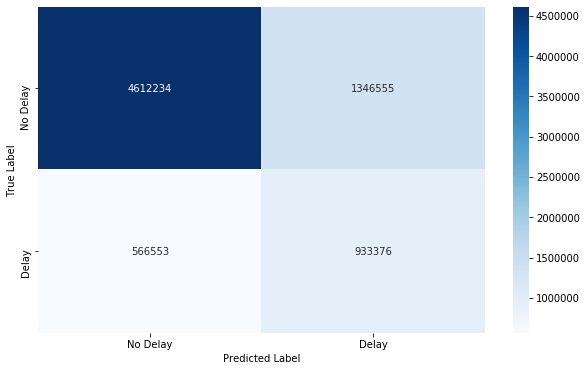

Text(0.5, 33.0, 'Predicted Label')

In [0]:
index = ['No Delay', 'Delay']
columns = ['No Delay', 'Delay']

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [0]:
numeric_metadata = predict_train.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
coef = model.coefficients

weights_arr = []
feature_arr = []

for index in numeric_metadata:
  idx = (index['idx'])
  weights_arr.append(float(coef[idx]))
  feature_arr.append(index['name'])

weightsDF = sqlContext.createDataFrame(zip(feature_arr,weights_arr), schema=['feature', 'weight'])
weightsDF.sort("weight", ascending=False).toPandas()

Out[6]:

,feature,weight
0,PRIOR_DEP_DELAY,0.463881
1,AVG_DEST_DELAY,0.250507
2,AVG_ORIGIN_DELAY,0.249295
3,OP_CARRIER_woe_encoded,0.045962
4,FOG_woe_encoded,0.034597
5,DISTANCE,0.032388
6,CT_DEL15,0.027122
7,FOG_arr_woe_encoded,0.014158
8,ORIGIN_PR,0.005914
9,Season_woe_encoded,0.000642


Comparing to our initial baseline run on Logistic Regression using the 6-Month dataset, we see significant improvement in all evaluation metrics. Furthermore, the feature coefficients that we observe here are consistent with the baseline. In particular, **TAIL_NUM**, **DEP_TIME_BLK**, and our new engineered feature, **PRIOR_DEL15** (which indicates delay state of tail numbers) are negative and correlated with delays. week_of_year is also negative, which indicates there is a linear relationship, albeit a weak one, between delays and seasonality.

## Random Forest
<img src='https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png'> 

Image Source: Wikipedia, *Random Forests*, April 2021.

**Random Forests** are based on decision trees and bagging. It is an ensemble technique in that it creates many decision trees, each split on a random subset of data and features, then combines the output of all the trees. This reduces overfitting and variance in order to improve prediction accuracy. <br>
Two of the most important [parameters](https://spark.apache.org/docs/2.2.0/api/java/org/apache/spark/mllib/tree/RandomForest.html) include:
- **maxDepth** - Maximum depth of a tree. Deeper trees are more expressive (potentially allowing higher accuracy), but they are also more costly to train and are more likely to overfit
- **numTrees** - Number of trees in the random forest. Increasing the number of trees will decrease the variance in predictions, improving the model’s test-time accuracy.

In [0]:
rf = RandomForestClassifier(labelCol="label", featuresCol="Scaled_features", weightCol="classWeights", maxDepth=10, numTrees=100)
rf_Model = rf.fit(train)
rf_train = rf_Model.transform(train)
rf_predictions = rf_Model.transform(test)

evaluator = BinaryClassificationEvaluator()
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(rf_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(rf_predictions)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(rf_predictions, {evaluator.metricName: 'areaUnderPR'})))

y_true = rf_predictions.select(['label']).collect()
y_pred = rf_predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred, digits=4))

rf_Model.save(FILE_PATH + "RF_MODEL_04092021_maxDepth10_numTrees100")

The area under ROC for train set is 0.7946
The area under ROC for test set is 0.7876
Test Area Under Precision-Recall Curve: 0.5830
 precision recall f1-score support

 0.0 0.8987 0.7965 0.8445 5958789
 1.0 0.4432 0.6435 0.5249 1499929

 accuracy 0.7657 7458718
 macro avg 0.6710 0.7200 0.6847 7458718
weighted avg 0.8071 0.7657 0.7803 7458718

Out[8]:

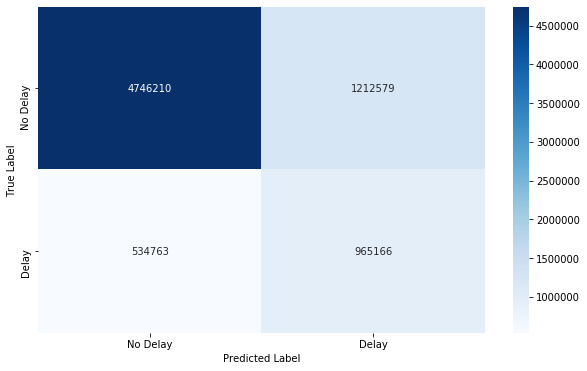

Text(0.5, 33.0, 'Predicted Label')

In [0]:
index = ['No Delay', 'Delay']
columns = ['No Delay', 'Delay']

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [0]:
numeric_metadata = rf_train.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
coef = rf_Model.featureImportances

weights_arr = []
feature_arr = []

for index in numeric_metadata:
  idx = (index['idx'])
  #print(index, coef[idx])
  weights_arr.append(float(coef[idx]))
  feature_arr.append(index['name'])

weightsDF = sqlContext.createDataFrame(zip(feature_arr,weights_arr), schema=['feature', 'weight'])
weightsDF.sort("weight", ascending=False).toPandas()

Out[9]:

,feature,weight
0,PRIOR_DEL15_woe_encoded,0.311535
1,PRIOR_DEP_DELAY,0.297561
2,AVG_ORIGIN_DELAY,0.138180
3,AVG_DEST_DELAY,0.091196
4,DEP_TIME_BLK_woe_encoded,0.054090
5,TAIL_NUM_woe_encoded,0.032951
6,OP_CARRIER_woe_encoded,0.011187
7,week_of_year_woe_encoded,0.009493
8,CT_DEL15,0.009465
9,SIG_WEATHER_woe_encoded,0.007990


The **Random Forest** classifier can compute feature importance according to the mean decrease in gini impurity. When constructing decision trees, a selected feature is used to make a decision on how to divide the data into two separate sets so that the splits are as homogeneous as possible in terms of labels (delay vs non-delay). The feature that has the highest decrease in impurity is selected as the node to split upon. Since we have many decision trees in our classifier, for each feature we can see how on average it decreases the impurity. The average decrease over all trees in the forest is the measure of a feature's importance. All the importances are normalized to sum to 1. We can see from our results that our engineered features, **PRIOR_DEL15** (binary variable), **PRIOR_DEP_DELAY** (minutes), and **AVG_ORIGIN_DELAY** (minutes), are considered as the most important features when constructing decision trees.

## Gradient Boosted Trees
Boosting algorithms play a crucial role in dealing with bias variance trade-off. Unlike bagging algorithms, which only controls for high variance in a model, boosting controls both the aspects (bias & variance), and is considered to be more effective. Like **Random Forests**, **Gradient Boosted Trees** are ensembles of decision trees and iteratively train trees to minimize a loss function. During each iteration, the algorithm uses the current ensemble to predict the label of each training instance and then compares the prediction against the true label. The dataset is re-labeled to emphasize training instances with poor predictions so that in the next iteration, the decision tree will help correct for the previous mistakes. Re-labeling instances is defined by a loss function. With each iteration, the algorithm further reduces the loss function on the training data. <br>

Some [parameters](https://spark.rstudio.com/reference/ml_gradient_boosted_trees) include: <br>
- **maxBins** - maximum number of bins used for discretizing continuous features and for choosing how to split on features at each node.
- **maxDepth** - maximum depth of the tree (nonnegative).
- **maxIter** - maximum number of iterations
- **featureSubsetStrategy** - The number of features to consider for splits at each tree node. 
  - "auto": Choose automatically for task: If num_trees == 1, set to "all". If num_trees > 1 (forest), set to "sqrt" for classification and to "onethird" for regression.
  - "all": use all features
  - "onethird": use 1/3 of the features
  - "sqrt": use use sqrt(number of features)
  - "log2": use log2(number of features)
  - "n": when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features. (default = "auto")
- **minInfoGain** - minimum information gain for a split to be considered at a tree node. Should be at least 0.0.
- **subsamplingRate** - fraction of the training data used for learning each decision tree, in range (0, 1]
- **stepSize** - learning rate

In [0]:
gbt = GBTClassifier(labelCol = "label", featuresCol="Scaled_features", maxIter=30, maxDepth=15, maxBins=32, weightCol="classWeights", stepSize=0.1, 
                    featureSubsetStrategy="all", minInfoGain=0.0, subsamplingRate=0.8)
GBT_Model = gbt.fit(train)
gbt_train = GBT_Model.transform(train)
gbt_predictions = GBT_Model.transform(test)

evaluator = BinaryClassificationEvaluator()
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(gbt_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(gbt_predictions)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'areaUnderPR'})))

y_true = gbt_predictions.select(['label']).collect()
y_pred = gbt_predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred, digits=4))

GBT_Model.save(FILE_PATH + "GBT_MODEL_04092021_maxIter30_maxDepth15_maxBins32_stepSize01_minInfoGain00_subsamplingRate0.8")

The area under ROC for train set is 0.8360
The area under ROC for test set is 0.7966
Test Area Under Precision-Recall Curve: 0.6089
 precision recall f1-score support

 0.0 0.9014 0.7968 0.8459 5958789
 1.0 0.4475 0.6537 0.5313 1499929

 accuracy 0.7680 7458718
 macro avg 0.6744 0.7253 0.6886 7458718
weighted avg 0.8101 0.7680 0.7826 7458718

Out[14]:

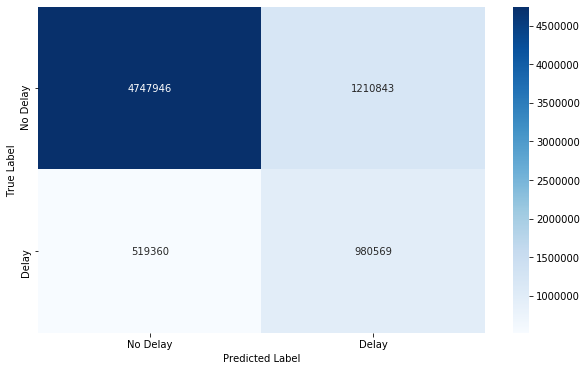

Text(0.5, 33.0, 'Predicted Label')

In [0]:
index = ['No Delay', 'Delay']
columns = ['No Delay', 'Delay']

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [0]:
numeric_metadata = gbt_train.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
coef = GBT_Model.featureImportances

weights_arr = []
feature_arr = []

for index in numeric_metadata:
  idx = (index['idx'])
  #print(index, coef[idx])
  weights_arr.append(float(coef[idx]))
  feature_arr.append(index['name'])

weightsDF = sqlContext.createDataFrame(zip(feature_arr,weights_arr), schema=['feature', 'weight'])
weightsDF.sort("weight", ascending=False).toPandas()

Out[15]:

,feature,weight
0,PRIOR_DEP_DELAY,0.156494
1,PRIOR_DEL15_woe_encoded,0.123331
2,AVG_ORIGIN_DELAY,0.067302
3,DEP_TIME_BLK_woe_encoded,0.061044
4,DEST_PR,0.056387
5,AVG_DEST_DELAY,0.051852
6,ORIGIN_PR,0.048252
7,TAIL_NUM_woe_encoded,0.045849
8,OP_CARRIER_woe_encoded,0.045108
9,DISTANCE,0.043287


Similar to Random Forest, we can compute feature importance for the **Gradient Boosted Tree** classifier. The interpretation and derivation are consistent since decision trees are used. We also see here that **PRIOR_DEL15** (binary variable), **PRIOR_DEP_DELAY** (minutes), and **AVG_ORIGIN_DELAY** (minutes), are considered as the most important features in explaining the target label.

## XGBoost
**XGBoost** is a high-performance implementation of the **Gradient Boosted Trees** algorithm. One of the primary differences between **XGBoost** and **GBT** is that **XGBoost** accounts for regularization to help control over-fitting and increase evaluation performance. Furthermore, model training is much faster compared to that of **GBT** since it supports parallelization during tree construction.

The Spark MLlib distribution of **XGBoost** is still in its preview stage and we found that it did not scale well on the full training set since it trains on a single Spark worker. Instead, we used **XGBoost4J**'s implementation of the algorithm, which is based on a Java Virtual Machine. 

During preliminary baseline runs on **Logistic Regression**, **Random Forest**, **Gradient Boosted Trees**, and **XGBoost** on the 6-month dataset, we saw that **XGBoost** had best performance in terms of F1-Score on delays. So we focused on hyperparameter tuning for **XGBoost**. However, we were unsuccessful in running cross-validation on the algorithm, so tuning was performed manually via trial-and-error on a subset of the training set for faster training and evaluation. Specifically, the training set was based from Q1 2016 to the end of Q2 2017 and the test set was based on Q3 and Q4 of 2017. The hyperparameters resulting from many tests provided our best estimate to be applied on the full training set.

#### XGBoost Documentation
[Parameter Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html) <br>
[Parameter Tuning Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)

In [0]:
xgb_classifier = XGBoostClassifier(labelCol="label", featuresCol="Scaled_features", weightCol="classWeights", treeMethod="hist", 
                                   missing=0.0, nthread=1, numWorkers=16, objective = "binary:logistic", evalMetric = "auc",
                                   alpha=5.0,
                                   colsampleBytree=0.8,
                                   eta=0.1,
                                   gamma = 2.0,
                                   lambdaBias = 3.0,
                                   maxDepth=15,
                                   minChildWeight=1.0,
                                   numRound = 50,
                                   subsample=0.8, 
                                   scalePosWeight=1.0)


xgb_model = xgb_classifier.fit(train)
xgb_train = xgb_model.transform(train)
xgb_predictions = xgb_model.transform(test)

evaluator = BinaryClassificationEvaluator()
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(xgb_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(xgb_predictions)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(xgb_predictions, {evaluator.metricName: 'areaUnderPR'})))

y_true = xgb_predictions.select(['label']).collect()
y_pred = xgb_predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred, digits=4))

xgb_model.save(FILE_PATH + "XGB_MODEL_04092021_paramtuned")

The area under ROC for train set is 0.8337205908724119
Test_SET (Area Under ROC): 0.8053893729686107
Test Area Under Precision-Recall Curve: 0.62
 precision recall f1-score support

 0.0 0.9040 0.8012 0.8495 5958789
 1.0 0.4561 0.6622 0.5401 1499929

 accuracy 0.7732 7458718
 macro avg 0.6801 0.7317 0.6948 7458718
weighted avg 0.8140 0.7732 0.7873 7458718

Out[11]:

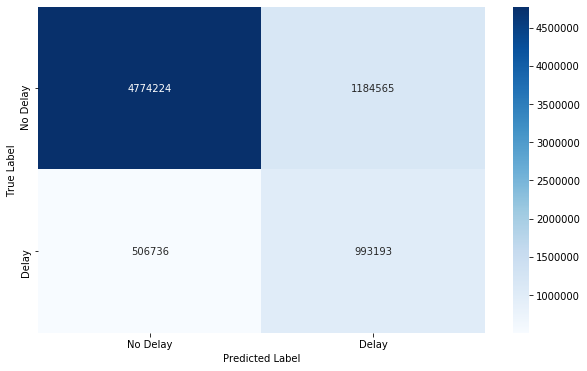

Text(0.5, 33.0, 'Predicted Label')

In [0]:
index = ['No Delay', 'Delay']
columns = ['No Delay', 'Delay']

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [0]:
feature_map = xgb_model.nativeBooster.getScore("","gain").toList()
py_list = [feature_map.apply(i) for i in range(feature_map.size())]

list_weights = []
for i in py_list:
  x = i.toString().split(',')
  list_weights.append(x)
  
feature_arr = []
weight_arr = []

for j in list_weights:
  feature_arr.append(j[0].strip('('))
  weight_arr.append(j[1].strip(')'))
  
coef_dict = dict(zip(feature_arr, weight_arr))
coef_dict = [(int(x[0].strip('f')),x[1]) for x in coef_dict.items()]
coef_dict = dict(coef_dict)

for k,v in coef_dict.items():
  coef_dict[k] = float(v)
  
  
numeric_metadata = xgb_train.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')

for line in numeric_metadata:
  idx = line['idx']
  if idx in coef_dict.keys():
    line['gain'] = coef_dict[idx]
    
test_dict = sorted(numeric_metadata, key=lambda x: x['gain'])[-10:]
pd.DataFrame(test_dict).sort_values("gain", ascending=False)

Out[12]:

,idx,name,gain
9,14,PRIOR_DEL15_woe_encoded,12038.824502
8,23,PRIOR_DEP_DELAY,741.433978
7,20,AVG_ORIGIN_DELAY,152.409698
6,21,AVG_DEST_DELAY,81.298773
5,0,DEP_TIME_BLK_woe_encoded,57.079665
4,4,SIG_WEATHER_woe_encoded,53.671053
3,2,TAIL_NUM_woe_encoded,48.353580
2,6,SIG_WEATHER_arr_woe_encoded,36.296791
1,1,OP_CARRIER_woe_encoded,31.639275
0,25,DEST_PR,22.305330


Obtaining feature importance from **XGBoost** was tricky since the getScore function outputs a Java Object and is not readily readable in Python.
The getScore function allows the user to specify our feature importance is calculated. In particular, "gain" is based on the average information gain across all splits the feature is used in and results in a similar interpretation of how we computed feature importance for **Random Forest** and **GBT**. The list of feature importance above is the ten greatest features with the highest gain. We can see that our three engineered features that performed well in our previous tree-based ensemble models appear once again as the most important features here. We also see that two engineered weather features appear in the top list of features (**SIG_WEATHER** and **SIG_WEATHER_arr**), whereas the previous tree methods did not deem any weather features as important.

### Hyperparameter Tuning

We also tried using the **Hyperopt** library to help with automated hyperparameter tuning. Hyperopt requires four basic steps to implement:
- **Define an objective function to minimize.** The function needs to be user-defined and include the classifier to train, the fit upon the training set, evaluation against the test set, and a metric as a loss function. We defined negative Delay F1 as the "loss."
- **Define the hyperparameter search space.** For each hyperparameter, we specify a stochastic expression that defines the distribution that we think contains the optimal value. 
  - **alpha** - L1 regularization term on weights. Increasing this value will make model more conservative.
  - **colsampleBylevel** - the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.
  - **colsampleBytree** - the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
  - **eta** - Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
  - **gamma** - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
  - **lambdaBias** - L2 regularization term that can be applied to the model’s bias.
  - **maxDepth** - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
  - **minChildWeight** - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. The larger min_child_weight is, the more conservative the algorithm will be.
  - **numRound** - The number of rounds for boosting.
  - **subsample** - Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
- **Specify the search algorithm.** Hyperopt uses stochastic tuning algorithms that perform a more efficient search of the hyperparameter space than a deterministic grid search. We use the default choice, Tree Parzen Estimators, which take a Bayesian optimization approach that accounts for the hyperparameter combinations it has seen already when choosing the next set of hyperparameters to evaluate. By choosing parameter combinations in an informed way, the optimization process focuses on areas of the parameter space that would yield the best validation scores. This approach typically requires less iterations to reach the optimal set of hyperparameter values since it also disregards areas of the parameter space that it believe would not improve the objective function.
- **Specify the total number of evaluations.** We defined this at 100 to keep reasonable training times.
- **Run the Hyperopt function fmin().** fmin() takes the items we defined in the previous steps and identifies the set of hyperparameters that minimizes the objective function.

Tuning was performed on the subset of the training set, specifically from Q1 2016 to the end of Q2 2017. The test set was based on Q3 and Q4 of 2017. This was to shorten the training time as reasonably as we could. The hyperparameters that Hyperopt finds would be our best estimate of the hyperparameters to be used on the full training set. Hyperopt took about 8 hours to complete 100 evaluations of hyperparameter combinations. However, times will vary depending on cluster resources and how wide the parameter search space is defined.
The code implementation can be found in a separate notebook found [here](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120636674/command/439895120636675).

In [0]:
xgb_classifier = XGBoostClassifier(labelCol="label", featuresCol="Scaled_features", weightCol="classWeights", treeMethod="hist", 
                                   missing=0.0, nthread=1, numWorkers=16, objective = "binary:logistic", evalMetric = "auc",
                                   alpha=5.87,
                                   colsampleBylevel = 0.95,
                                   colsampleBytree=0.62,
                                   eta=0.06,
                                   gamma = 0.27,
                                   lambdaBias = 3.55,
                                   maxDepth=28,
                                   minChildWeight=4.0,
                                   numRound = 90,
                                   subsample=0.73,
                                   scalePosWeight=1.0)

xgb_model = xgb_classifier.fit(train)
xgb_train = xgb_model.transform(train)
xgb_predictions = xgb_model.transform(test)

evaluator = BinaryClassificationEvaluator()
print("The area under ROC for train set is {:.4f}".format(evaluator.evaluate(xgb_train)))
print("The area under ROC for test set is {:.4f}".format(evaluator.evaluate(xgb_predictions)))
print("Test Area Under Precision-Recall Curve: ", "{:.4f}".format(evaluator.evaluate(xgb_predictions, {evaluator.metricName: 'areaUnderPR'})))

y_true = xgb_predictions.select(['label']).collect()
y_pred = xgb_predictions.select(['prediction']).collect()

print(classification_report(y_true, y_pred, digits=4))

xgb_model.save(FILE_PATH + "XGB_MODEL_04132021_paramtuned_hyperopt_v2")

The area under ROC for train set is 0.9101
The area under ROC for test set is 0.8052
Test Area Under Precision-Recall Curve: 0.6196
 precision recall f1-score support

 0.0 0.8989 0.8352 0.8659 5958789
 1.0 0.4891 0.6268 0.5495 1499929

 accuracy 0.7933 7458718
 macro avg 0.6940 0.7310 0.7077 7458718
weighted avg 0.8165 0.7933 0.8023 7458718

Out[6]:

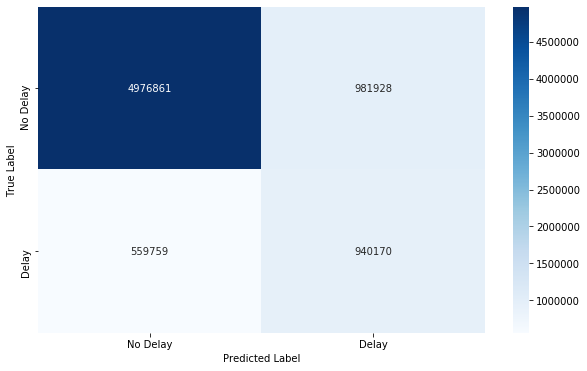

Text(0.5, 33.0, 'Predicted Label')

In [0]:
index = ['No Delay', 'Delay']
columns = ['No Delay', 'Delay']

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [0]:
feature_map = xgb_model.nativeBooster.getScore("","gain").toList()
py_list = [feature_map.apply(i) for i in range(feature_map.size())]

list_weights = []
for i in py_list:
  x = i.toString().split(',')
  list_weights.append(x)
  
feature_arr = []
weight_arr = []

for j in list_weights:
  feature_arr.append(j[0].strip('('))
  weight_arr.append(j[1].strip(')'))
  
coef_dict = dict(zip(feature_arr, weight_arr))
coef_dict = [(int(x[0].strip('f')),x[1]) for x in coef_dict.items()]
coef_dict = dict(coef_dict)

for k,v in coef_dict.items():
  coef_dict[k] = float(v)
  
  
numeric_metadata = xgb_train.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')

for line in numeric_metadata:
  idx = line['idx']
  if idx in coef_dict.keys():
    line['gain'] = coef_dict[idx]
    
test_dict = sorted(numeric_metadata, key=lambda x: x['gain'])[-10:]
pd.DataFrame(test_dict).sort_values("gain", ascending=False)

Out[7]:

,idx,name,gain
9,14,PRIOR_DEL15_woe_encoded,2651.622435
8,23,PRIOR_DEP_DELAY,60.714634
7,20,AVG_ORIGIN_DELAY,17.754565
6,4,SIG_WEATHER_woe_encoded,7.910093
5,0,DEP_TIME_BLK_woe_encoded,6.684463
4,21,AVG_DEST_DELAY,6.228858
3,2,TAIL_NUM_woe_encoded,5.596807
2,1,OP_CARRIER_woe_encoded,5.043507
1,6,SIG_WEATHER_arr_woe_encoded,4.046271
0,24,ORIGIN_PR,3.949270


The new hyperparameters we receive from **Hyperopt** led to some improvement in our evaluation for Delay F1-Score. The tuned parameters also lead to significantly different feature importance in terms of gain. Most notably, the gain for **PRIOR_DEL15** is reduced for the tuned model. Thus, we hypothesize that the prior model likely overemphasized **PRIOR_DEL15**. The increase of the L1 regularization term, alpha, likely contributed to this change and deterred the model from overfitting on the training set. It is also interesting to note that of the top 10 most important features, seven of them are engineered. Furthermore, similar to our previous **XGBoost** model, we see that two weather-related features, **SIG_WEATHER** and **SIG_WEATHER_arr**, have some importance in our model, but still have significantly less predictive capability than our primary **PRIOR_DEL15** variable.

Upon further comparison of the hyperparameters between our first and second XGBoost models, the biggest differences were the number of rounds of boosting, minimum child weight, and maximum depth. The Hyperopt parameters were all larger than the original parameters so the model was able to become more complex and prone to overfitting in some regard, but more conservative in terms of node partitioning.

## Model Summary

| Model                    | Test AUC    | Test AUPRC  | Non-Delay F1 | Delay F1 | Training and Evaluation Time* |
| -----------              | ----------- | ----------- | -----------  | -------- | ------------- |
| Logistic Regression      | 0.7632      | 0.5394      | 0.8282       | 0.4939   | 7.88 minutes  |
| Random Forest            | 0.7876      | 0.5830      | 0.8445       | 0.5249   | 31.53 minutes |
| Gradient Boosted Trees   | 0.7966      | 0.6089      | 0.8459       | 0.5313   | 1.22 hours    |
| XGBoost                  | 0.8054      | 0.62        | 0.8495       | 0.5401   | 19.72 minutes |
| XGBoost (Hyperopt)       | 0.8052      | 0.6196      | 0.8659       | 0.5495   | 38.71 minutes |

* Training times vary considerably with cluster configuration and the number of cluster users. The model times shown do not share consistent resources.

# __Section 6__ - Conclusion

### Baseline Models
For our baseline we used logistic regression and several decision tree-based models on the six-month dataset. While logistic regression had the poorest performance of all the baseline models, with a delay F1 score of 0.350, it gave us some insight into what features could potentially be important for identifying delays and provided inspiration for additional feature engineering.

All of our tree-based models achieved similar delay F1 scores, precisions, and recalls. Specifically, our models have higher recall than precision, which means that while they capture a majority of the outstanding delays, well over half of the flights identified as delayed are false positives.
### Features
Creating new features that corresponded to airport delay state or tail number delay state led to the greatest performance gains. These flight-related features were considered the most important and predictive of the target label and we were surprised to learn that weather features were generally not considered important by our models.

There are some possible reasons for the effectiveness of prior delay state. The air travel system is an interconnected network, with earlier flights affecting later flights. A delay that occurs early in the day at one airport can contribute to later delays at the same or different airports. It’s also possible that an airport’s average delay metric acted as a proxy for weather or other conditions that caused delays.

### Final Models
Our final models were trained on a dataset consisting of all flights occurring from 2015 through 2018 and evaluated on a test set containing all 2019 flights. The performance of all models improved significantly from the baseline models, with F1 scores ranging from 0.494 for logistic regression to 0.5495 for XGBoost. Precision scores generally doubled to between 0.410 and 0.474, and recall scores ranged from 0.622 for logistic regression to 0.662 for XGBoost.

In addition to F1, we also evaluated area under the curve (AUC) and area under the precision recall curve (AUPRC). AUC values ranged from 0.763 for logistic regression to 0.805 for XGBoost. However, like accuracy, these scores reflect a bias towards predicting on-time flights due to the imbalance of the data set. The AUPRC scores appear to better reflect the model’s performance with respect to predicting delays, with scores ranging from 0.539 to 0.619. The relatively lower AUPRC means that our model is not able to correctly identify all the delays without misclassifying non-delays, and is only a modest improvement from the baseline of 0.5.
### Model Choice for Delay Prediction System
In the end, with all the engineered features, we see the best evaluation metrics from **XGBoost**,  although the differences are marginal among all the models. XGBoost differs from standard gradient boosted trees in that it uses more advanced regularization and is able to reduce the number of feature splits that need to be evaluated, leading to faster performance.  With the many possible parameters that **XGBoost** supports, we see many benefits in utilizing this algorithm. It is highly customizable and can be tuned for even greater performance. The only caveat is that it is unstable when coupled with MLLib's **CrossValidator** and would crash. However, we were able to overcome this problem using the **Hyperopt** library, and used Bayesian optimization techniques for hyperparameter tuning. Hyperparameters gained from this approach achieved a 1.74% increase in our primary evaluation metric, Delay F1, relative to that from the manually tuned **XGBoost** model.

**XGBoost** was also impressive in its speed. It took approximately seven to ten minutes for the model to train on the full training set. To potentially further decrease training time, we investigated dimension reduction techniques like PCA. However, improvements were marginal at best and we did not feel it would be appropriate to compromise on model interpretability when going this route. 

### Scalability
For this application, we don’t consider model training time to be the most important attribute. Since flights and weather readings both behave seasonally, model retraining could occur once per quarter in order for the model to learn the latest seasonal changes in both flights and weather. Features like airport PageRank could be retrained once per year to account for any changes in flight volume among airports. However, if a significant global event occurs that heavily impacts air travel, such as a pandemic or a terrorist attack, then the model would need to be reworked and new features would need to be engineered. Nevertheless, model retraining should not be required more frequently than monthly to every few months. Therefore a model training time of several hours is satisfactory.

With respect to prediction speed, tree-based models provide fast predictions and there are only about 14,000 flights on a typical day, so we expect these models are more than adequate.

Even though we do  not anticipate problems with training time, there are methods to improve training time. Repartitioning and prudent caching of the train and test sets improved scalability and resulted in faster training. We also found that performance was dependent on cluster health, as the tuning process would also crash if there were multiple teams using the shared cluster. We suspect there are still values in the parameter space that are unexplored that could produce better results. This can be achieved if we increase the number of evaluations from 100 or fine-tune our parameter search-space by specifying more specific distributions of possible values. However, this is not currently achievable with the current cluster resources.

### Lessons Learned
Using the scikit-learn package for model evaluation to generate classification reports and confusion matrices was inefficient since it required performing the collect action on the test dataframe. For example, outputing a classification report took nearly the same amount of time as model training for **XGBoost** on the full dataset. In retrospect, we could have utilized MLLib's Evaluation functions like **BinaryClassificationMetrics** and **MulticlassMetrics**. However, it does seem counterintuitive that we would need to use MulticlassMetrics to compute F1-scores, accuracy, precision, and recall since we are dealing with a binary classification problem.

### Future Work
Even our best model provides a significant number of false positives and negatives. Both false positives and negatives could be detrimental in a business setting. Customers would be equipped with false information and act on the assumption of expecting a delay, when in fact, they should not. For example, customers could unnecessarily re-schedule flights or change airlines, which could cost the business more money and customer loss. 

In addition, our model predicts whether a flight will be delayed by fifteen minutes or more, however it provides no prediction regarding the length of a delay. The response actions that are appropriate for a two hour delay would not be appropriate for a twenty minute delay. A regression model that provides an estimate of the length of a delay would help airlines to decide how to respond to delays.

Finally, our model evaluates weather conditions two hours prior to scheduled departure. But are weather conditions improving or are they likely to get worse? The model could be improved if it considered forecasts of future weather.

# __Section 7__ - Course Concepts

### Categorical Features Encodings

The way we encoded our variables in our model proved critical to its success. A common and basic way to encode categorical variables is **one-hot encoding**. With this method, each category in a variable is split into its own column and given a 1 if the category is present, and a 0 if it is not. Thus, each categorical variable will create k-1 new columns, where k is the number of categories per column. While one-hot encoding will keep all the information about the variables, it can often introduce redundant information. The biggest reason it is often not a good idea to use one-hot encoding for large datasets is that it would introduce sparse vector representations of the columns, which would be costly to hold in memory and potentially introduce overfitting. On the scale of data that we are working with, each column adds an enormous amount to memory. Thus, we decided to encode our categorical variables using **weight-of-evidence encoding**. With this method, each column remains just one column. By looking at the weight-of-evidence encoded variable, you can determine which category favors the target being 1 or 0 (delay or no delay). It works by taking the natural logarithm of the probability that the target equals 1 (delay) divided by the probability that the target equals 0 (no delay).

Another method of encoding we used was **PageRank**. Originally, we wanted to include airport as an input to our model because certain airports may just generally have more delays. However, doing so could cause overfitting and there would be no way the model could deal with a case where a new airport is introduced. Thus, **one-hot-encoding** would not be possible, and weight-of-evidence would also lead to similar issues. Instead, we used **PageRank** to measure the "importance" of airports to the whole system. Even if a new airport were to be added in the test data, this method would work. In this network, the airports would be the nodes and the flight paths would be the edges, and this would be a directed graph. We assume that the more important airports will have more flights flying to and from. This could potentially indicate delays, as an airport with many flights may get backed up. The **PageRank** algorithm would output a probability distribution that represents how likely that airport will be involved in a random flight.

### Broadcast Joins

Another class concept that proved extremely useful to use during this project was broadcast joins. Compared to a regular join, a broadcast join performs a join by first broadcasting the smaller dataset to all of Spark's executors, then evaluating the join with each executor's partitions. This saves shuffling costs, as Spark can perform the join without shuffling any of the data in a large dataframe. In our case, this decreased the time of the joins immensely. We used broadcast joins to map stations to the weather dataframe, specifically broadcasting stations as it was the smaller dataframe. However, we did not use a broadcast join when joining the weather data to the airport data, as both datasets were rather large, so it did not make sense to broadcast either dataset to all of Spark's executors.

### Repartitioning

Repartitioning greatly improved the speed of our large, joined dataset. We learned that a partition should be not too small, but not too large for optimal efficiency. Partitioning correctly improves data scalability by dividing the data amongst multiple executors, allowing for parallel execution. It improves performance because data executions occur on fewer subsets of data.  Originally, we tried repartitioning the flight data by the join column that we created (location + date + hour). However, we found that our join took a very long time to execute because the data was split into too many (200) partitions. Our goal was to have between two and four partitions per core, which led to us choosing 32 partitions for a cluster of up to four workers for the weather, flight, and joined data.

### Feature Normalization

Lastly, we were able to determine that we should normalize some of our input variables, thanks to some of the lessons from this course (HW4). Specifically, we standardized features by removing the mean and scaling the variable to unit variance. This action removes data anomalies and reduces the impact of outliers that could sway the model. This method has been shown to improve model accuracy and the performance of loss optimization algorithms like gradient descent. Normalization gives equal weight to each variable so that no single variable could steer model performance in a certain direction just because it has larger numbers. We ended up normalizing all of our inputs, even the categorical variables after performing weight-of-evidence encoding.

# __Additional Information__
 * [Team Project Document](https://docs.google.com/document/d/1FWZUnwqDHeEc0sTXeZkXKME47kfAakpKNo6Rc1GOg0s/edit#)

# __Presentations__
 * [Mid-term presentation slide](https://docs.google.com/presentation/d/1eUf2B7PIRkBziMLWgpL0jVvqzsvU_RvFGHipJ2qUwzc/edit)
 * [Final presentation slide](https://docs.google.com/presentation/d/10MXj7BBtjEM_YWlR5_0Dz8D_5ZaBhtMoBBriDIqyzBE/edit#slide=id.p)
 * Internal Presentations:
   * [Airport Key in the Airline & Weather data](https://docs.google.com/presentation/d/1ktBcCRf9cQQ0_Vu92MTggNCXbaTqsrx-SXQ-arAC_8c/edit#slide=id.gc3efc35984_0_391)
   * [Relationship Between Different Time Fields in Flights Data](https://docs.google.com/presentation/d/1DQj_oq_zosPyz-llx8t6QpJ6impcGt-tsLCfwFgBWz0/edit#slide=id.p)
   * [Using Scalable Data Mining for Predicting Flight Delays](https://docs.google.com/presentation/d/1dtxkzZ2tKCnBx2vn4igi2Fs8mhdDLHuh-M747PdmXZw/edit#slide=id.p)
   
## Exploration Notebooks
 * [Create the Airport code to Station code mapping utility](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1434049882790134/command/1434049882790135)
 * [Verify weather coverage by using mapping utility](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/3608681281205062/command/3608681281205063)
 * [TimeZone UTC conversion](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1434049882791889/command/1434049882791890)
 * [Delay Study - Frank](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/3608681281205412/command/3608681281205413)
 * [Airline / weather data joining study](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/785654973965184/command/785654973965185)
 * [Study using UDF and agg/collect_list](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/3608681281227430/command/3608681281227431)
 * [Study how to use MLLib to build classifier with just Airline Data](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/3608681281224847/command/3608681281224848)
 * [Categorical Features Encoders](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4377823981612210/command/4377823981612211)
 * [Demo How to Use Encoders](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4480952025475379/command/4480952025475380)
 * [baseline models without encoding, based on final_joined_Mar20 dataset](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/3608681281228918/command/785654973956807)
 * [baseline models with encoding, based on chained_final_joined_Mar25 dataset](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4480952025476729/command/4480952025476769)
 * [generate train and test sets via encoding/pipelining/oversampling](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/528073926734987/command/37954262501289)
 * [model implementations](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/3553239981363371/command/439895120618209)
 * [HyperOpt playground](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120636674/command/439895120636675)
 * [Weather Feature Engineering](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120626286/command/439895120626287)
 * [Flights Feature Engineering](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120626158/command/439895120626159)
 * [Initial Feature Engineering both weather + flights](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1434049882789704/command/1434049882789705)

##  Submission of Weekly Lab Notes:
 * **Week 1 (3/14):** We read the provided literature and an additional related paper. We conducted EDA on the weather and airlines datasets, including evaluation of correlation matrices for the continuous variables and parsing through weather fields. Next, we focused on pre-processing necessary to join the weather and airline datasets, including linking weather stations to their corresponding airports, filtering out weather data for non-airport locations, and converting airline data into UTC time. Finally, we experimented with several baseline classification models, including Decision Trees, Random Forest, Naive Bayes, Gradient Boosted Trees, and Logistic Regression. We noticed that randomly splitting the table into train and test sets would cause data leakage since flights occurring on the same hours and days can be found in both train and test sets. We also implemented balancing of train/test labels since there are fewer records for delayed flights than non-delayed flights.
 * **Week 2 (3/21):** Weather features include temperature, dew point, cloud base, and severe weather. Airport parameters include the number of flights and the presence of delays on earlier flights. Built StandardScaler, OneHotEncoding, StringIndexer, and VectorAssembler in our pipeline. Researched PCA. We looked into Target Encoding, Leave One Encoding, Weight of Evidence as one-hot encoding alternatives. We considered hyperparameters for regularization, and interaction terms. Created a severe weather variable by combining and extracting composite fields from the weather table. Constructed a graph to create features such as node degree and PageRank. Implemented a baseline model using XGBoost and explored feature importance for various baseline models. Also played around with cross validation and hyperparameter tuning. Identified methods for running code in different notebooks, for a more modular approach. Determined partition key to balance the partition size and overhead.
 * **Week 3 (4/4):** Threw the kitchen sink at logistic regression and ran feature importance to find features predictive of delays, guiding us during feature selection. Imputed “999” for null values for LR in the features selected to use the full dataset. Encode categorical variables via weight-of-evidence to make the “999” continuous-agnostic and reduce dimensionality (in contrast to one-hot). Engineered airport pagerank to capture airport importance, arrival weather conditions, the “delay state” of the airport 2 hours prior to current flights, the prior delay status of tail numbers, and week number to capture seasonality. Added categorical variables for precipitation, thunder, fog, as well as precipitation %, weather intensity, etc. We found that flight and engineered flight features were predictive, while weather features were not. Some transformations were generating partitions that contained few records. So we repartitioned at key points to improve performance. Decided to use F1-Score for metric.
 * **Week 4 (4/11):** This week, we focused on fine-tuning our final models. We tried many different hyperparameters for XGBoost using the HyperOpt library, which is designed for large-scale hyperparameter optimization, and ran and timed our results. We also completed a toy logistic regression example that used RDDs and trained it on one day’s worth of flight data. The toy example did not use any Spark machine learning libraries. We created and cleaned-up our final project notebook. We added images and plots for better illustration of our work. Summarized the evaluation metrics for each model (Logistic Regression, Random Forests, Gradient Boosted Trees, XGBoost) in a table.
 * **Week 5 (4/14):** We re-ran our hyperparameter tuning for our models to ensure we had the best model. To optimize the training time, we used weight of evidence encoding for categorical variables, a broadcast join for airport code mapping, we repartitioned to avoid overhead of workers, and we cached our final dataset. In addition, we cleaned up our final notebook, finished writing the conclusion, and finalized the course concepts section. Lastly, we put together our presentation, including a final model comparison summary table and each model’s run times. We split the presentation up among us, and practiced our final presentation.